### imports

In [1]:
using Base.Threads

In [2]:
import Base.sort

In [3]:
using DifferentialEquations

In [4]:
using Plots; gr();

In [5]:
using DataStructures

In [6]:
#using ParameterizedFunctions

In [7]:
Plots.theme(:default)
default(dpi = 300,
 format=:png,
 titlefont = (12,
 "source sans pro"),
 legendfontsize = 6,
 guidefont = 8,
 tickfont = 8,
 framestyle = :zerolines,
 width=1.2,
 palette = :tab10,
)

### functions and struct definitions

In [8]:
struct Med            # Struct for specifying a medication/substance
    time::Real        # time in m
    type::String      # type of medication (if type is equal to a key in the params dict that value will be changed to the value of dose)
    dose::Float64     # dose of medication (varies with type)
end
    
mutable struct ExpMed # as above but with exponential decline
    time::Real
    type::String
    dose::Float64
    fade::Float64     # time * fade^(current_time - time) -> sets decline
end

In [9]:
function cycle(vec, n)
    return collect(Base.Iterators.flatten((Base.Iterators.repeated(vec, n))))
end

cycle (generic function with 1 method)

In [10]:
function vkf(ke,ki)
    8.314 * 293.15/96485.332 * log(ke/ki) * 1000
end

function vkf(ki)
    8.314 * 293.15/96485.332 * log(15/ki+1) * 1000
end

vkf (generic function with 2 methods)

In [11]:
function removenothing!(dict)
    for (key, val) in enumerate(dict)
        if val == nothing
            delete!(dict, key)
        end
    end
end

removenothing! (generic function with 1 method)

In [12]:
function setupstats()
    return Dict([
        ("t", []),
        ("vk", []),
        ("gkatpbar", []),
        ("gca", []),
        ("gkca", []),
    ])
end

setupstats (generic function with 1 method)

In [13]:
function savestats(i)
    global stats
    push!(stats["t"]    , i.t)
    push!(stats["vk"]    , i.p["vk"])
    push!(stats["gkatpbar"]    , i.p["gkatpbar"])
end


savestats (generic function with 1 method)

In [14]:
function sort(d::Dict)
    sorted_keys = map(x -> x[1], sort(pairs(d) |> collect, by=x->x[1]))
    sd = SortedDict()
    map(x -> sd[x] = d[x], sorted_keys)
    return sd
end

sort (generic function with 11 methods)

In [15]:
function values(d::Dict; sorted=false)
    if sorted
        return sorted_values(d)
    end
    map(x -> x[2], collect(pairs(d)))
end
    
function sortedvalues(d::Dict)
    map(x -> x[2], sort(pairs(d) |> collect, by=x->x[1]))
end

function sortedvalues(d::Dict{Any, Dict})
    reduce(vcat, map(x -> sortedvalues(x), map(x -> x[2], sort(pairs(d) |> collect, by=x->x[1]))))
end

sortedvalues (generic function with 2 methods)

In [16]:
function vecdiff(vec::Vector)
    last = vec[1]
    return_vec = []
    for val in vec[2:end]
        push!(return_vec, val - last)
        last = val
    end
    return return_vec
end

function vecdiff(vec, interval)
    vecdiff(vec) ./ (length(vec) ./ interval)
end

vecdiff (generic function with 2 methods)

In [17]:
function vector_to_matrix(vecvec::AbstractVector{T}) where T <: AbstractVector
    dim1 = length(vecvec)
    dim2 = length(vecvec[1])
    my_array = Array{eltype(vecvec[1]), 2}(undef, dim1, dim2)
    @inbounds @fastmath for i in 1:dim1, j in 1:dim2
        my_array[i,j] = vecvec[i][j]
    end
    return my_array
end

function vec_to_matrix(vecvec::AbstractVector{T}) where T <: AbstractVector
    return vector_to_matrix(vecvec)
end

vec_to_matrix (generic function with 1 method)

In [18]:
function scale_solution_columns(sol)
    mat = vec_to_matrix(sol.u)
    mat[:,2] *= 100
    mat[:,3] *= 750
    mat[:,6] /= 7
    if size(mat)[1] == 9
        mat[:,9] *= 10
    end
    return mat
end

scale_solution_columns (generic function with 1 method)

<img src="https://www.vielhilftviel.com/notes/figures/marinelli_2018_model.svg" alt="Drawing" style="max-width: 800px;"/>

### set default params

In [19]:
function reset_params()
    return Dict(
    "gca"      => 1000,     # maximal conductance ca membran channel
    "gkca"     => 50,       # maximal conducatnce ca dependet k channels
    "gk"       => 2700,     # maxiaml conductance of k ? 
    "gkatpbar" => 25000,    # maximal conductance of atp dependent k channels
        
    "vca"      => 25,       # nernst potential ca2+
    "vm"       => -20,      # shapre parameter ca2+ activation
    "sm"       => 12,       # shape parameter ca2+ activation
        
    "vk"       => -75,      # nernst potential k
    "k_ext"    => 30,       # extracellular k
    "k_i_ext"  => 30,       # initial extracellular k
    "k_int"    => 280,      # intracellular k
        
    "sn"       => 5,        # shape parameter k
    "taun"     => 20,       # time constant rectifying current
    "nin"      => -16,      # shape parameter rectifying current
    "kd"       => 0.5,      # MgADP^2 factor KATP activation function 
    "kdd"      => 17,       # MgADP factor KATP activation function
    "ktd"      => 26,       # ADP3- factor KATP activation function
    "ktt"      => 1,        # ATP4- factor KATP activation function
    "atot"     => 3000,     # apt + adp
    "alpha"    => 5.18e-18, # current to ion flux conversion factor
    "vcyt"     => 1.15e-12, # volume cytosol
    "kpmca"    => 0.2,      # pmca pump rate ca2+ cell membrane
    "kserca"   => 0.4,      # serca pump rate ca2+ er
    "pleak"    => 2.0e-4,   # leak across er membrane
    "kuni"     => 0.4,      # rate of mitochonria uniporters
    "knaca"    => 0.001,    # activity of mitochndrial ca na exchanger NCLX
    "Cm"       => 5300,     # membrane capacitance
    "fca"      => 0.01,     # fraction of ca2+ not bound to buffers
    "sigmam"   => 100,      # ration of mitochonidria to cytosol volume
    "sigmaer"  => 31,       # ration of ER to cytosol volume
    "Jgk"      => 0.001,    # glucokinase flux
        
    "k1"       => 30,       # params for pfk activity
    "k2"       => 1,        # params for pfk activity
    "k3"       => 50000,    # params for pfk activity 
    "k4"       => 1000,     # params for pfk activity
    "famp"     => 0.02,     # params for pfk activity
    "fatp"     => 20,       # params for pfk activity
    "ffbp"     => 0.2,      # params for pfk activity 
    "fbt"      => 20,       # params for pfk activity
    "fmt"      => 20,       # params for pfk activity
    "kpfk"     => 0.06,     # params for pfk activity
        
    "vpfk"     => 0.01,     # flux rate of pfk
    "taua"     => 300000,   # d ADP/dt time constant
    "kCaPDH"   => 200,      # factor for pdh activation function
    "vpdh"     => 0.009,    # flux rate of pdh
        
    "dummy"     => []       # put array to set type to Dict{String, Any}
    )
end 

reset_params (generic function with 1 method)

### pfk activity

In [20]:
function pfk_activity(atp,adp,f6p,fbp,amp, params)
	# (alpha,beta,gamma,delta);
	# (0,0,0,0);
    
	weight1=1;
	topa1=0;
	bottom1=1;
	
	# (0,0,0,1);
	weight2=atp^2/params["k4"];
	topa2=topa1;
	bottom2=bottom1+weight2;
	
	# (0,0,1,0);
	weight3=f6p^2/params["k3"];
	topa3=topa2+weight3;
	bottom3=bottom2+weight3;
	
	# (0,0,1,1);
	weight4=(f6p*atp)^2/(params["fatp"]*params["k3"]*params["k4"]);
	topa4=topa3+weight4;
	bottom4=bottom3+weight4;
	
	# (0,1,0,0);
	weight5=fbp/params["k2"];
	topa5=topa4;
	bottom5=bottom4+weight5;
	
	# (0,1,0,1)
	weight6=(fbp*atp^2)/(params["k2"]*params["k4"]*params["fbt"]);
	topa6=topa5;
	bottom6=bottom5+weight6;
	
	# (0,1,1,0)
	weight7=(fbp*f6p^2)/(params["k2"]*params["k3"]*params["ffbp"]);
	topa7=topa6+weight7;
	bottom7=bottom6+weight7;
	
	# (0,1,1,1)
	weight8=(fbp*f6p^2*atp^2)/(params["k2"]*params["k3"]*params["k4"]*params["ffbp"]*params["fbt"]*params["fatp"]);
	topa8=topa7+weight8;
	bottom8=bottom7+weight8;
	
	# (1,0,0,0);
	weight9=amp/params["k1"];
	topa9=topa8;
	bottom9=bottom8+weight9;
	
	# (1,0,0,1);
	weight10=(amp*atp^2)/(params["k1"]*params["k4"]*params["fmt"]);
	topa10=topa9;
	bottom10=bottom9+weight10;
	
	# (1,0,1,0);
	weight11=(amp*f6p^2)/(params["k1"]*params["k3"]*params["famp"]);
	topa11=topa10+weight11;
	bottom11=bottom10+weight11;
	
	# (1,0,1,1);
	weight12=(amp*f6p^2*atp^2)/(params["k1"]*params["k3"]*params["k4"]*params["famp"]*params["fmt"]*params["fatp"]);
	topa12=topa11+weight12;
	bottom12=bottom11+weight12;
	
	# (1,1,0,0)
	weight13=(amp*fbp)/(params["k1"]*params["k2"]);
	topa13=topa12;
	bottom13=bottom12+weight13;
	
	# (1,1,0,1);
	weight14=(amp*fbp*atp^2)/(params["k1"]*params["k2"]*params["k4"]*params["fbt"]*params["fmt"]);
	topa14=topa13;
	bottom14=bottom13+weight14;
	
	# (1,1,1,0) -- the most active state of the enzyme;
	weight15=(amp*fbp*f6p^2)/(params["k1"]*params["k2"]*params["k3"]*params["ffbp"]*params["famp"]);
	topa15=topa14;
	topb=weight15;
	bottom15=bottom14+weight15;
	
	# (1,1,1,1);
	weight16=(amp*fbp*f6p^2*atp^2)/(params["k1"]*params["k2"]*params["k3"]*params["k4"]*params["ffbp"]*params["famp"]*params["fbt"]*params["fmt"]*params["fatp"]);
	topa16=topa15+weight16;
	bottom16=bottom15+weight16;
	
	Jpfk= params["vpfk"]*(topb + params["kpfk"]*topa16)/bottom16;
end

pfk_activity (generic function with 1 method)

### medication handling

In [21]:
function handle_medication(med, i::Any) 
    if med.type ≡ "tolbutamid"
        if med.dose > 0
                i.p["gkatpbar"] = reset_params()["gkatpbar"] - 1250 * med.dose
            else
                i.p["gkatpbar"] = reset_params()["gkatpbar"]
            end
    elseif med.type ≡ "Dz"
        if med.dose > 0
            i.p["gkatpbar"] = reset_params()["gkatpbar"] + 1250 * med.dose
        else
            i.p["gkatpbar"] = reset_params()["gkatpbar"]
        end
    elseif med.type ≡ "Tg"
        if med.dose > 0
                i.p["kserca"] = reset_params()["kserca"] - 0.04 * med.dose
            else
                i.p["kserca"] = reset_params()["kserca"]
            end
    elseif med.type ≡ "KCl"
            i.p["k_ext"] = i.p["k_i_ext"] + med.dose
    elseif med.type ≡ "nifedipin"
        Bool(med.dose) ? i.p["gca"] = 500 : i.p["gca"] = 1000
    elseif med.type ≡ "glucose"
        i.p["Jgk"] = med.dose / 1000
    elseif med.type ⊆ keys(params)
        i.p[med.type] = med.dose
    end
end

handle_medication (generic function with 1 method)

In [22]:
function calc_dosage(m::Med, i)
    handle_medication(m, i)
    return true
end

function calc_dosage(m::ExpMed, i)
    m.dose *= m.fade^((i.t - m.time*6000)/6000)
    #println(m.dose)
    handle_medication(m, i)
    if m.dose ≤ 0.01
        m.dose = 0
        return true
    end
    return false
end

calc_dosage (generic function with 2 methods)

In [23]:
function parse_medications(i)
    try
        savestats(i)
    catch
        print("")
    end
    for m ∈ i.p["meds"]
        if 6000 * m.time ≤ i.t
            if calc_dosage(m, i);
                filter!(n -> n ≠ m, i.p["meds"])
            end
        end
    end
end

parse_medications (generic function with 1 method)

### eq system

- y[1] = $V$
- y[2] = $K$
- y[3] = $Ca$
- y[4] = $Ca_{er}$
- y[5] = $Ca_{m}$
- y[6] = $ADP$
- y[7] = $F6P$
- y[8] = $FBP$

In [24]:
#vk = (k_ext::Real,k_int::Real) -> 8.314 * 293.15/96485.332 * log((10+k_ext)/(280+k_int)) * 1000

In [25]:
#function sys(dy, y, params, t)
#    #v, n, c, cer, cam, adp, f6p, fbp = y
#
#    # calc atp/adp ratios
#    rad     = sqrt(-4*y[6]^2+(params["atot"]-y[6])^2);
#    atp     = (params["atot"]+rad-y[6])/2;
#    mgadp   = 0.165*y[6]; # magnesium adp complex
#    adp3m   = 0.135*y[6]; # adp for transport into matrix  (löffler petrides s. 238)
#    atp4m   = 0.05 *atp;  # atp for transport into matrix (löffler petrides s. 238)
#    amp     = y[6]^2/atp; # adenosine monophosphate
#    
#    # flux activation functions
#    topo    = 0.08+0.89*mgadp^2/params["kdd"]^2+0.16*mgadp/params["kdd"] ;
#    bottomo = (1+mgadp/params["kdd"])^2*(1+atp4m/params["ktt"] + adp3m/params["ktd"]) ;
#    katpo   = topo/bottomo;                                                 # I_K(ATP) activation function
#    minf    = 1/(1+exp((params["vm"]-y[1])/params["sm"]));                  # ca pmca activation function
#    ninf    = 1/(1+exp((params["nin"]-y[1])/params["sn"]));                 # rectifing current acti
#    qinf    = y[3]^2/(params["kd"]^2+y[3]^2);                               # I_K(Ca) activation functin
#    # fluxes                                                                   
#    katpo = 0.009
#    ik      = params["gk"]*y[2]*(y[1]-params["vk"]);                        # rectifying current
#    ikca    = -params["gkca"]*qinf*(params["vk"]-y[1]);                     # ca dependent k current
#    ikatp   = params["gkatpbar"]*katpo*(y[1]-params["vk"]);                 # k flux atp dependent
#    ica     = params["gca"]*minf*(y[1]-params["vca"]);                      # ca flux for action potentials
#    
#    Jer     = params["kserca"]*y[3] - params["pleak"]*(y[4]-y[3]);          # ca flux density across er membrane
#    Jm      = params["kuni"]*y[3] - params["knaca"]*(y[5]-y[3]);            # ca flux density across mitochonidium
#    Jmem    = -(params["alpha"]/params["vcyt"]*ica + params["kpmca"]*y[3]); # ca flux density (cell membrane)
#                                                                               
#    # glycolitic oscillations                                                                                       
#    Jpfk    = pfk_activity(atp, y[6], y[7], y[8], amp, params)              # pfk activity
#    sinfty  = y[5]/(y[5]+params["kCaPDH"]);                                 # Michaelis-Menten function   
#    Jpdh    = params["vpdh"]*sinfty*sqrt(y[8]);                             # pdh activity
#    
#    #save_stats(amp, atp, katpo, minf, ninf, qinf, ik, ikca, Jer, ikatp, Jm, ica, Jmem, Jpfk, sinfty, Jpdh);
#    dy[1] = -(ica + ik + ikca + ikatp)/params["Cm"]
#    dy[2] = -(y[2]-ninf)/params["taun"]
#    dy[3] = params["fca"]*(Jmem - Jm - Jer)
#    dy[4] = params["fca"]*params["sigmaer"]*Jer
#    dy[5] = params["fca"]*params["sigmam"]*Jm
#    dy[6] = (atp-exp((1+2.2 * Jpdh/(Jpdh+0.05)) * (1-y[3]/0.35))*y[6])/params["taua"]
#    dy[7] = 0.3*(params["Jgk"]-Jpfk)
#    dy[8] = Jpfk-Jpdh/2
#end

In [26]:
function sys(dy, y, params, t)
    #v, n, c, cer, cam, adp, f6p, fbp = y

    # calc atp/adp ratios
    rad     = sqrt(-4*y[6]^2+(params["atot"]-y[6])^2);
    atp     = (params["atot"]+rad-y[6])/2;
    mgadp   = 0.165*y[6]; # magnesium adp complex
    adp3m   = 0.135*y[6]; # adp for transport into matrix  (löffler petrides s. 238)
    atp4m   = 0.05 *atp;  # atp for transport into matrix (löffler petrides s. 238)
    amp     = y[6]^2/atp; # adenosine monophosphate
    
    #params["vk"] = 8.314 * 293.15/96485.332 * log((params["k_ext"])/(y[2]*1e5)) * 1000
    params["vca"] = vkf(params["k_ext"], y[3] * 20e5)
    params["vk"] = vkf(params["k_ext"], y[2] * 20e5)
    
    # flux activation functions
    topo    = 0.08+0.89*mgadp^2/params["kdd"]^2+0.16*mgadp/params["kdd"] ;
    bottomo = (1+mgadp/params["kdd"])^2*(1+atp4m/params["ktt"] + adp3m/params["ktd"]) ;
    katpo   = topo/bottomo;                                                 # I_K(ATP) activation function
    minf    = 1/(1+exp((params["vm"]-y[1])/params["sm"]));                  # ca pmca activation function
    ninf    = 1/(1+exp((params["nin"]-y[1])/params["sn"]));                 # rectifing current acti
    qinf    = y[3]^2/(params["kd"]^2+y[3]^2);                               # I_K(Ca) activation functin
    # fluxes                                                                   
    katpo = 0.009
    ik      = params["gk"]*y[2]*(y[1]-params["vk"]);                        # rectifying current
    ikca    = -params["gkca"]*qinf*(params["vk"]-y[1]);                     # ca dependent k current
    ikatp   = params["gkatpbar"]*katpo*(y[1]-params["vk"]);                 # k flux atp dependent
    ica     = params["gca"]*minf*(y[1]-params["vca"]);                      # ca flux for action potentials
    
    Jer     = params["kserca"]*y[3] - params["pleak"]*(y[4]-y[3]);          # ca flux density across er membrane
    Jm      = params["kuni"]*y[3] - params["knaca"]*(y[5]-y[3]);            # ca flux density across mitochonidium
    Jmem    = -(params["alpha"]/params["vcyt"]*ica + params["kpmca"]*y[3]); # ca flux density (cell membrane)
                                                                               
    # glycolitic oscillations                                                                                       
    Jpfk    = pfk_activity(atp, y[6], y[7], y[8], amp, params)              # pfk activity
    sinfty  = y[5]/(y[5]+params["kCaPDH"]);                                 # Michaelis-Menten function   
    Jpdh    = params["vpdh"]*sinfty*sqrt(y[8]);                             # pdh activity
    
    #save_stats(amp, atp, katpo, minf, ninf, qinf, ik, ikca, Jer, ikatp, Jm, ica, Jmem, Jpfk, sinfty, Jpdh);
    dy[1] = -(ica + ik + ikca + ikatp)/params["Cm"]
    dy[2] = -(y[2]-ninf)/params["taun"]
    dy[3] = params["fca"]*(Jmem - Jm - Jer)
    dy[4] = params["fca"]*params["sigmaer"]*Jer
    dy[5] = params["fca"]*params["sigmam"]*Jm
    dy[6] = (atp-exp((1+2.2 * Jpdh/(Jpdh+0.05)) * (1-y[3]/0.35))*y[6])/params["taua"]
    dy[7] = 0.3*(params["Jgk"]-Jpfk)
    dy[8] = Jpfk-Jpdh/2
end

sys (generic function with 1 method)

### runner functions

In [27]:
labels = ["v" "n" "c" "cer" "cm" "adp" "f6p" "fbp"];
y0 = [-60; 0.001; 0.1; 185; 100; 780; 60; 40];

In [28]:
function trysolve(problem, callback, abstol=1e-3, reltol=1e-1)
    if abstol <= 1e-21
        return nothing
    end
    try
        if callback
            cb = PeriodicCallback(parse_medications, 100)
            return solve(problem, Tsit5(), saveat=100, reltol=reltol, abstol=abstol, callback=cb)
        else
            return solve(problem, Tsit5(), saveat=100, reltol=reltol, abstol=abstol)
        end
    catch err
        if isa(err, DomainError)
            return trysolve(problem, callback, abstol*=1e-3, reltol*1e-3)
        else
            println(err)
        end
    end
end

#function trysolve(problem)
#    return solve(problem, Tsit5(), saveat=10)
#end

trysolve (generic function with 3 methods)

In [29]:
function simulate(system)
    if :change_params ∈ keys(system)
        for (key,val) ∈ system.change_params
                system.params[key] = val;
            end
    end
    if :meds ∈ keys(system)
        system.params["meds"] = system.meds
    end
    
    problem = ODEProblem(system.ode_func, system.y0, (0.0, system.time), system.params)
    @time solution = trysolve(problem, :meds ∈ keys(system))
    
    if solution == nothing
        return solution
    end
    
    matrix = scale_solution_columns(solution)
    if :plot_params ∈ keys(system) || "plot_params" ∈ keys(system)
        solution_plot = plot(
            solution.t/6000, 
            matrix[:,system.plot_params];
            label = hcat(labels[settings.plot_params]...),
            system.plot_args...)
    else
        solution_plot = plot(solution.t/6000, matrix;
            label = hcat(labels[settings.plot_params]...),
            system.plot_args...)
    end
    return (solution, matrix, solution_plot)
end

simulate (generic function with 1 method)

In [30]:
function loopvals(key::String, vals::Array, settings)
    sols = Dict()
    sols_mat = Dict()
    plots = Dict()
    
    @threads for val ∈ vals
        local s = deepcopy(settings)
        s.params[key] = val
        s.plot_args[:title] = key * " = " * string(val)
        try
            sol, mat, p = simulate(s)
            sols[val] = p
            sols_mat[val] = p
            plots[val] = p
        catch
            println("simulate " * key * " = " * string(val) * " failed")
        end
    end
    acc_plot = plot(
        sortedvalues(plots)...,
        dpi=300,
        label = hcat(labels[settings.plot_params]...),
    )
    return (sols, sols_mat, plots, acc_plot)
end

function loopvals(key1::String, vals1::Vector, key2::String, vals2::Vector, settings)
    local sols::Dict{Any, Dict}     = Dict()
    local sols_mat::Dict{Any, Dict} = Dict()
    local plots::Dict{Any, Dict}    = Dict()
    
    @threads for val1 ∈ vals1
            sols[val1] = Dict()
            sols_mat[val1] = Dict()
            plots[val1] = Dict()
        @threads for val2 ∈ vals2
            local s = deepcopy(settings)
            s.params[key1] = val1
            s.params[key2] = val2
            s.plot_args[:title] = key1 * " = " * string(val1) * ", " * key2 * " = " * string(val2)
            try
                sol, mat, p = simulate(s)
                sols[val1][val2] = sol
                sols_mat[val1][val2] = mat
                plots[val1][val2] = p
            catch
                println("simulate " * key1 * " = " * string(val1) * " " * key2 * " = " * string(val2) *" failed")
            end
        end
    end
    acc_plot = plot(
        sortedvalues(plots)...,
        dpi=300,
        label = hcat(labels[settings.plot_params]...),
    )
    
    return (sols, sols_mat, plots, acc_plot)
end


loopvals (generic function with 2 methods)

### simulations

  6.860782 seconds (63.69 M allocations: 1.257 GiB, 5.21% gc time, 83.98% compilation time)
  6.905791 seconds (65.92 M allocations: 1.292 GiB, 5.18% gc time, 1.45% compilation time)
  1.367854 seconds (60.51 M allocations: 971.468 MiB, 14.87% gc time, 1.68% compilation time)
  0.984129 seconds (60.06 M allocations: 943.277 MiB, 22.15% gc time)
  1.018918 seconds (62.54 M allocations: 984.618 MiB, 21.40% gc time)
  1.025136 seconds (62.82 M allocations: 991.651 MiB, 21.27% gc time)
  1.008539 seconds (61.34 M allocations: 966.117 MiB, 19.88% gc time)
  1.054928 seconds (63.02 M allocations: 990.292 MiB, 19.00% gc time)
  1.061518 seconds (63.32 M allocations: 997.720 MiB, 18.89% gc time)


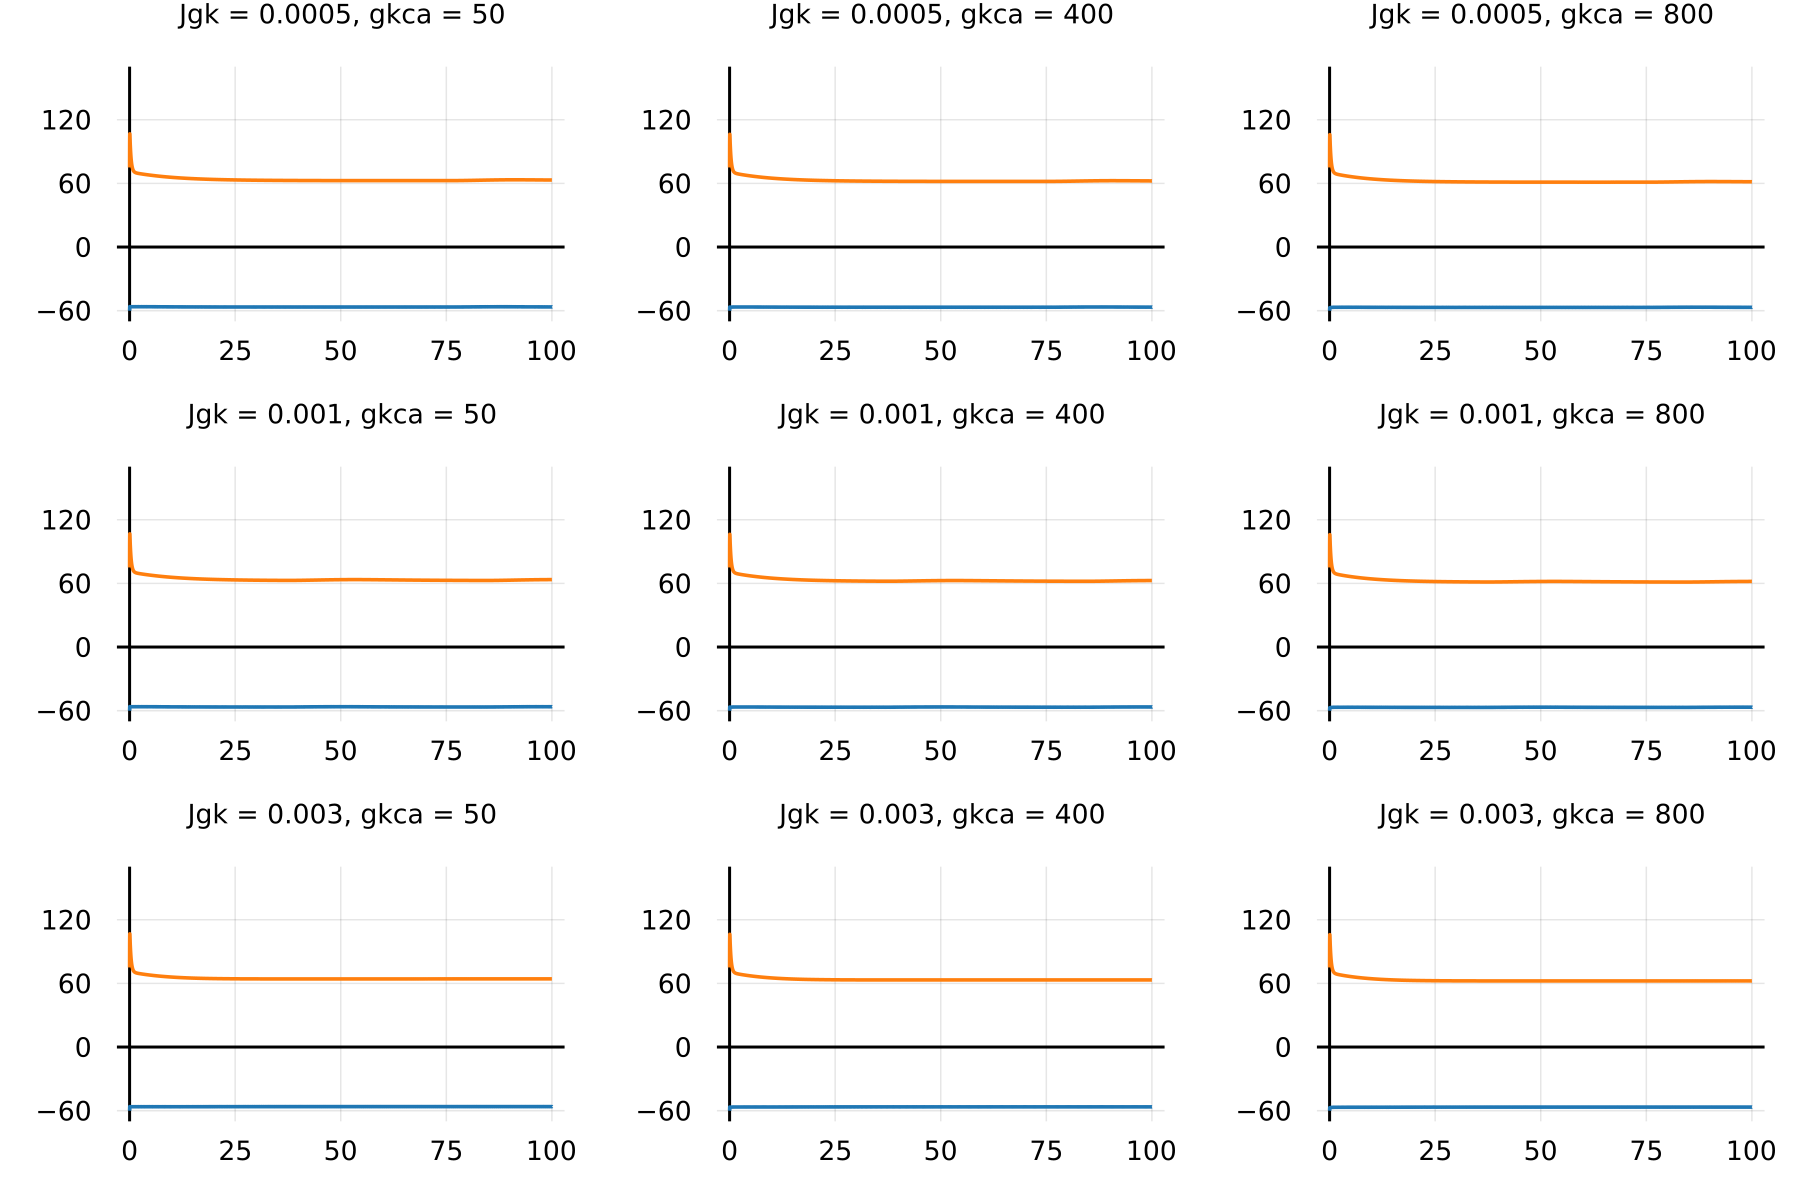

In [31]:
settings = (
    ode_func = sys,
    y0 = y0,
    time = 600000.0,
    plot_args = Dict(),
    plot_params = [1,3],
    params = reset_params(),
    change_params = Dict(
        "vpdh" => 0.009,
        )
);

settings.plot_args[:legend] = false

sols, mats, plots, p = loopvals(
    "Jgk",
    [0.0005, 0.001, 0.003],
    "gkca",
    [50, 400, 800],
    settings)

plot(
    p,
    titlefontsize = 6,
    tickfontsize = 6,
    yticks = -60:60:150,
    ylims = (-70, 170),
)

In [32]:
savefig("vary_jgk_gkca.svg")

  1.107125 seconds (63.48 M allocations: 996.347 MiB, 19.63% gc time)
  1.184295 seconds (63.96 M allocations: 1006.045 MiB, 23.92% gc time)
  1.215513 seconds (64.60 M allocations: 1018.331 MiB, 23.30% gc time)


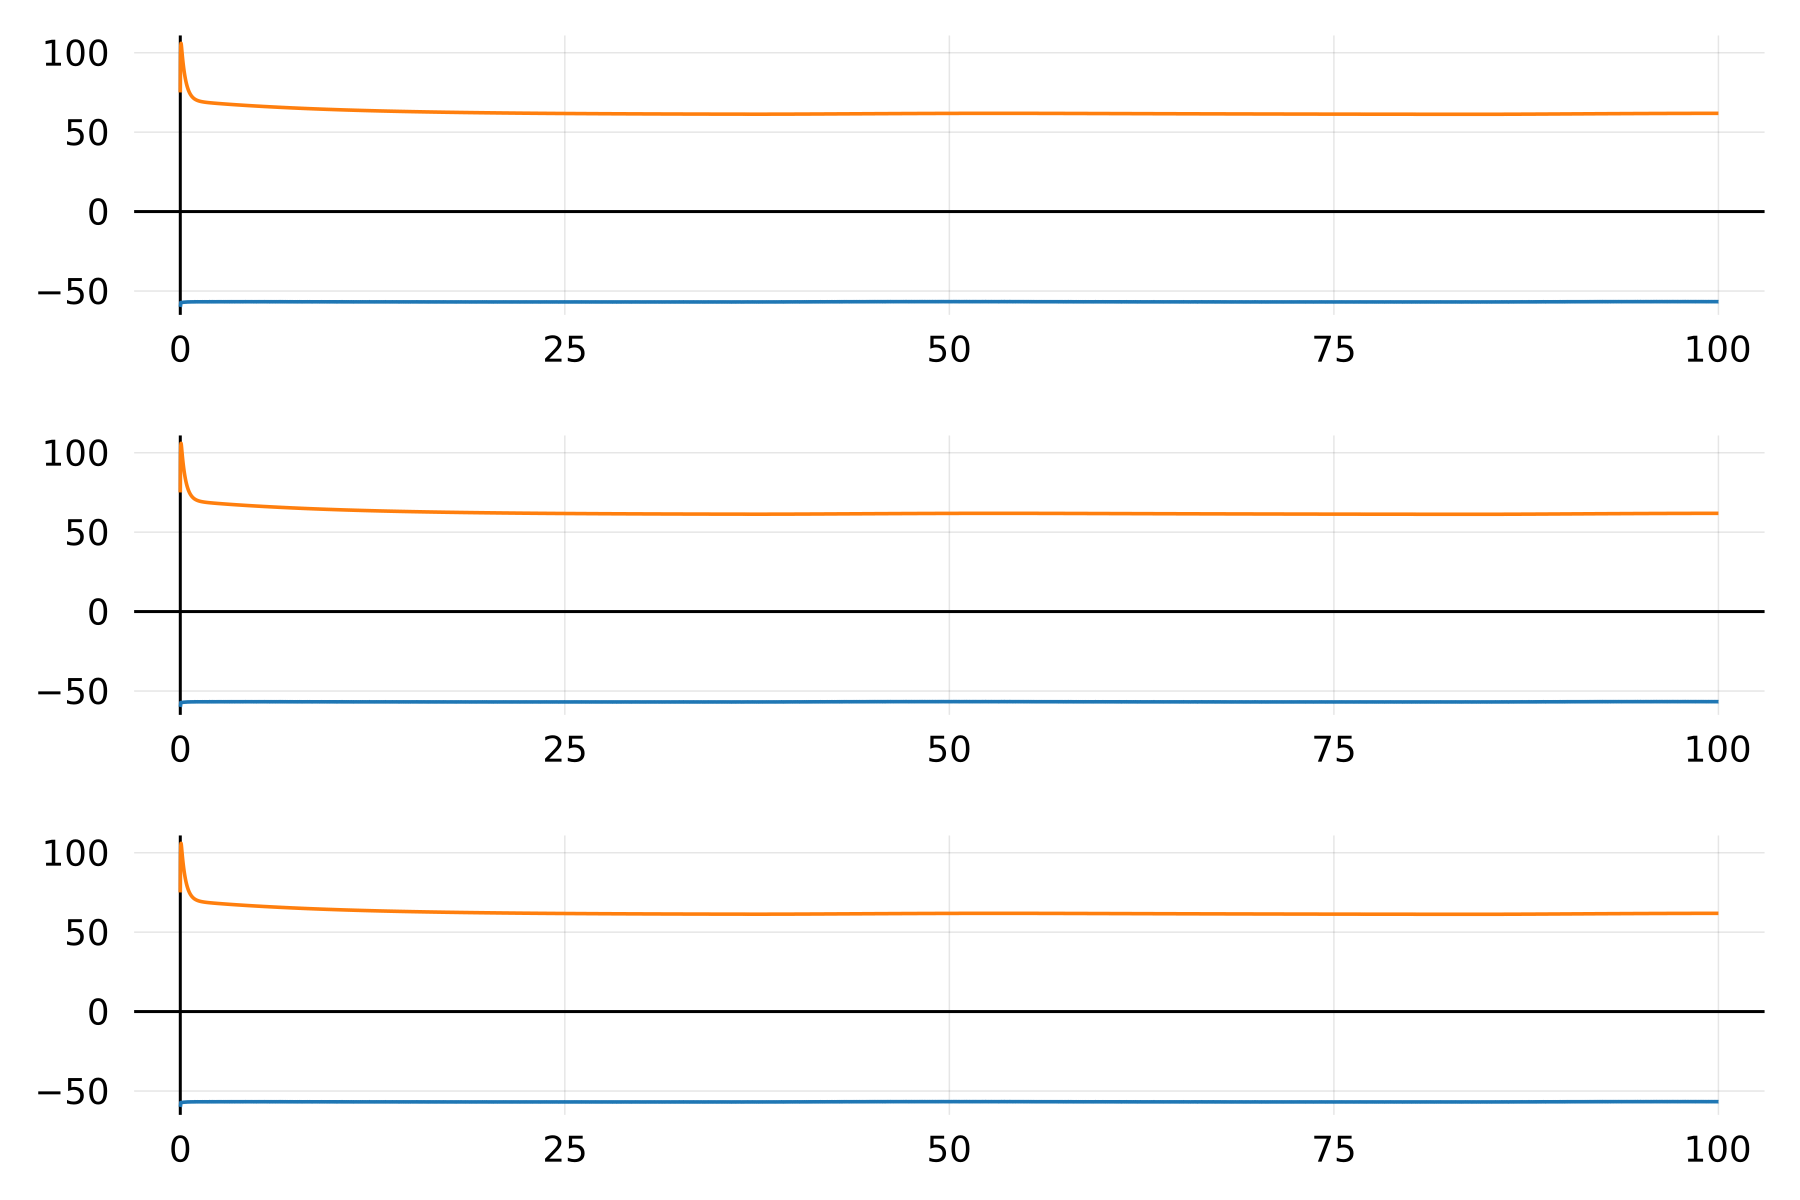

In [33]:
settings = (
    ode_func      = sys,
    y0            = y0,
    time          = 600000.0,
    plot_args     = Dict(),
    params        = reset_params(),
    plot_params   = [1,3],
    change_params = Dict(
           "vpdh" => 0.009,
           "gkca" => 800
        )
);

settings.plot_args[:legend] = false

vk = [-65, -60, -55];
plots = Dict();
problems = [];
vals = vk
key = "vk"

_, _, plots, p = loopvals(key, vals, settings)

plot(sortedvalues(plots)..., dpi=300, layout = (3,1), title="")
#plot(p, yticks = -60:30:200)

  2.859398 seconds (53.83 M allocations: 843.157 MiB, 5.11% gc time)


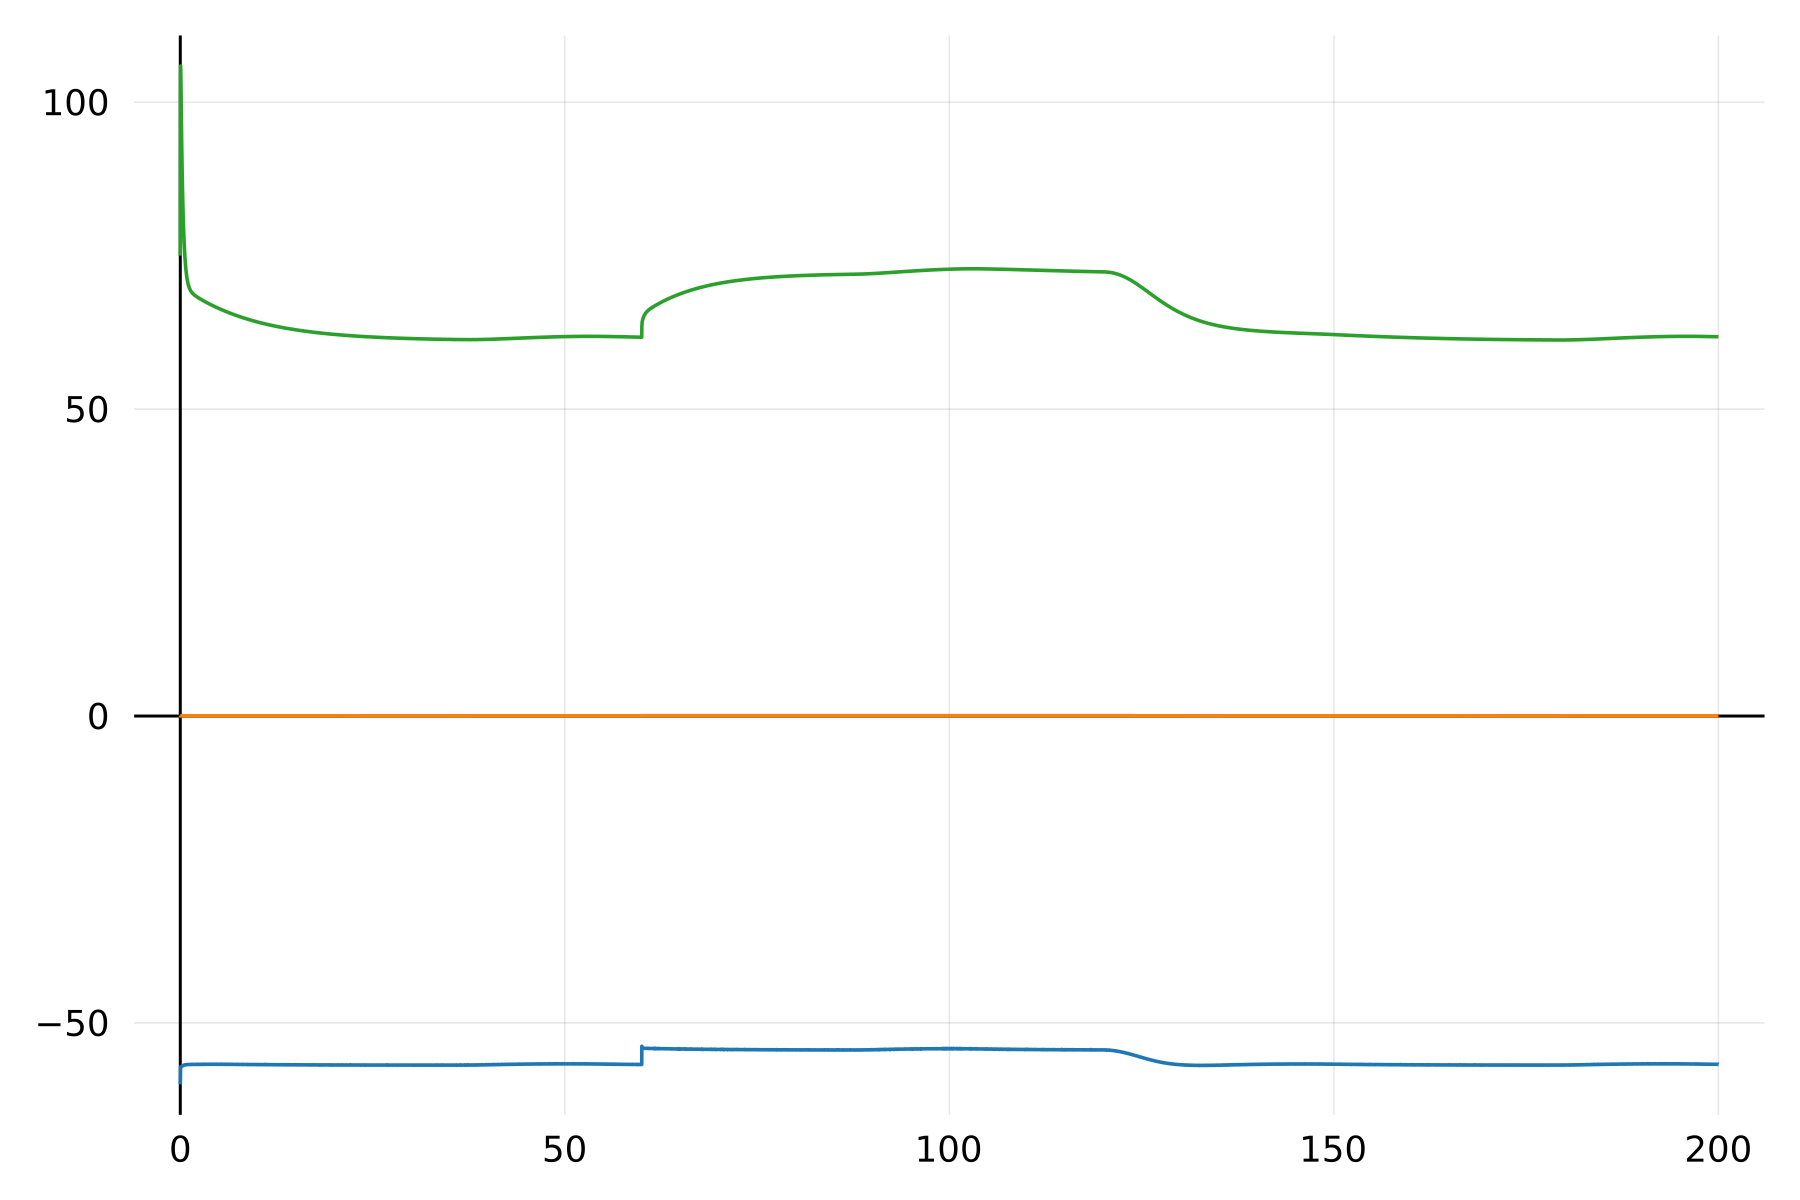

In [34]:
settings = (
    ode_func      = sys,
    y0            = y0,
    time          = 200 * 6000,
    plot_args     = Dict([(:legend, false)]),
    params        = reset_params(),
    plot_params   = [1,2,3],
    change_params = Dict(
           "vpdh" => 0.009,
           "gkca" => 800
        ),
    meds = [
        #Med(60, "Dz", 40)
        Med(60, "KCl", 20)
        ExpMed(120, "KCl", 20, 0.999)
        #ExpMed(90, "tolbutamid", 20, 0.9999)
        ]
);

_, _, p = simulate(settings);

plot(p)

  1.298810 seconds (79.49 M allocations: 1.221 GiB, 26.24% gc time)
  1.309618 seconds (80.27 M allocations: 1.234 GiB, 26.02% gc time)
  1.319032 seconds (80.68 M allocations: 1.241 GiB, 25.84% gc time)
  1.359819 seconds (81.68 M allocations: 1.257 GiB, 25.06% gc time)


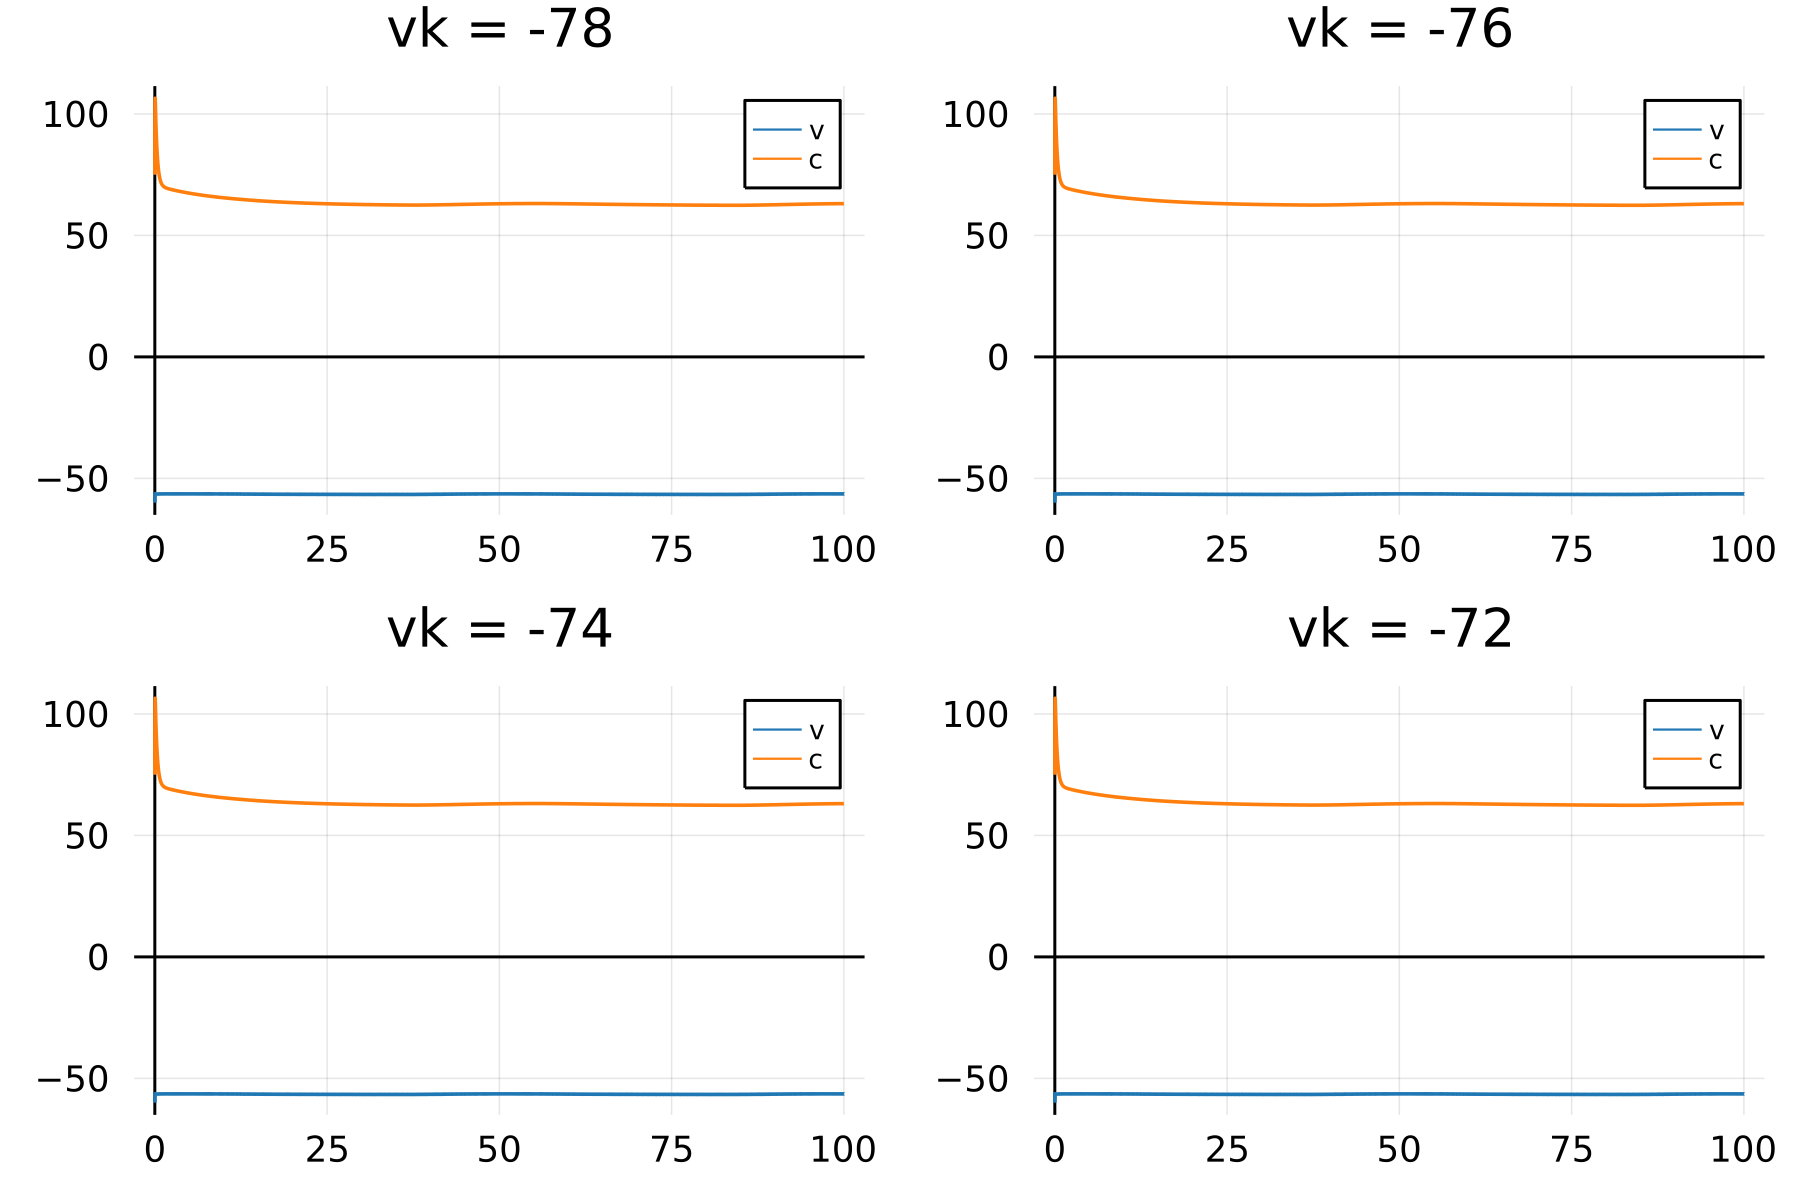

In [35]:
settings = (
    ode_func      = sys,
    y0            = y0,
    time          = 100 * 6000,
    plot_args     = Dict(),
    params        = reset_params(),
    plot_params   = [1,3],
    change_params = Dict(
           "vpdh" => 0.007,
           "gkca" => 200
        ),
);

settings.plot_args[:legend] = true

nernst_ca = [15,20,25,30]
nernst_k = [-78,-76,-74,-72]
gkca = [900]
Vcom = [60.26]

vals = nernst_k
key = "vk"

sol, mat, plots, p = loopvals(key, vals, settings)

plot(p)

  1.257679 seconds (77.74 M allocations: 1.193 GiB, 20.50% gc time)
  1.306100 seconds (81.31 M allocations: 1.254 GiB, 19.74% gc time)
  1.308067 seconds (81.42 M allocations: 1.257 GiB, 19.72% gc time)
  1.313052 seconds (81.55 M allocations: 1.259 GiB, 19.64% gc time)


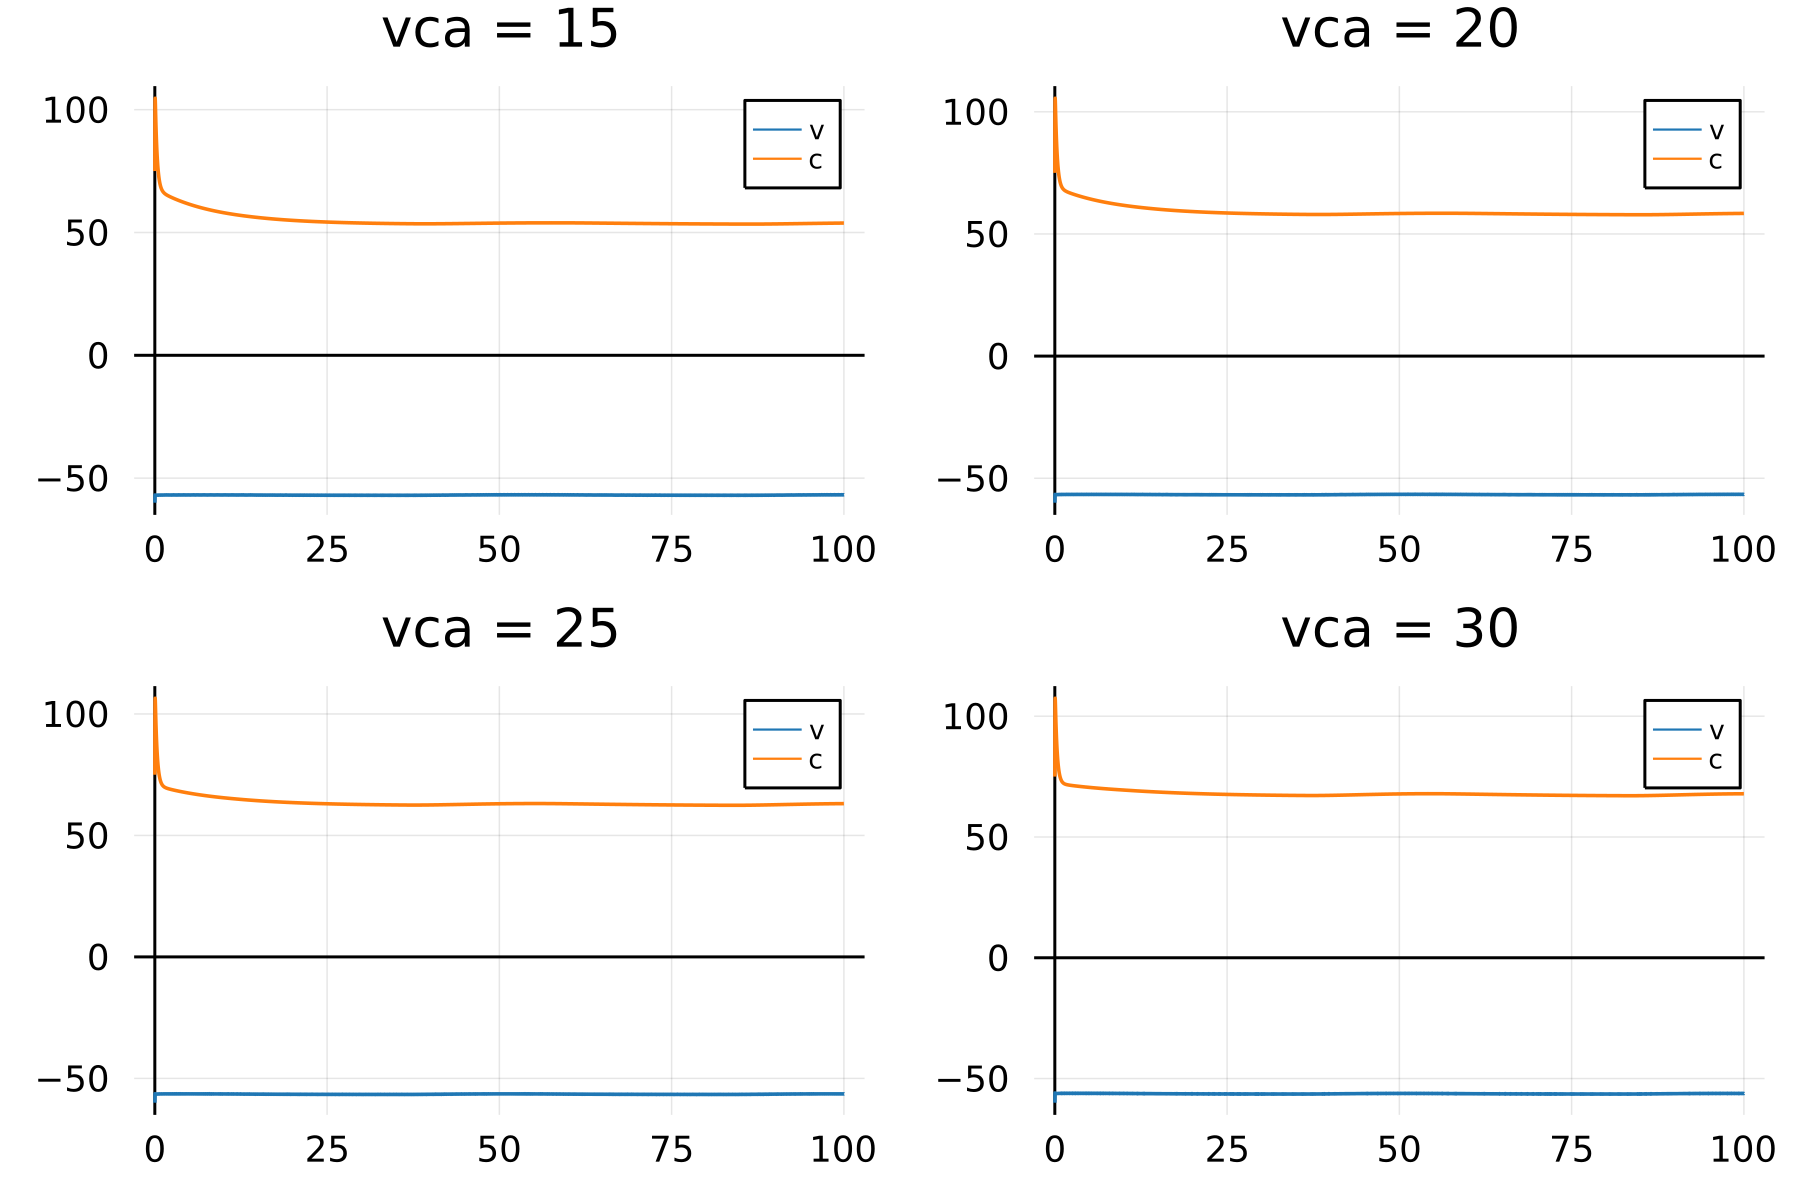

In [36]:
settings = (
    ode_func      = sys,
    y0            = y0,
    time          = 100 * 6000,
    plot_args     = Dict(),
    params        = reset_params(),
    plot_params   = [1,3],
    change_params = Dict(
           "vpdh" => 0.007,
           "gkca" => 200
        ),
);

_, _, plots, p = loopvals("vca", [15,20,25,30], settings)
plot(p)

  1.368286 seconds (82.19 M allocations: 1.261 GiB, 24.32% gc time)
  1.373568 seconds (82.53 M allocations: 1.267 GiB, 24.22% gc time)
  1.417962 seconds (84.83 M allocations: 1.304 GiB, 23.46% gc time)
  1.423043 seconds (84.93 M allocations: 1.306 GiB, 23.38% gc time)


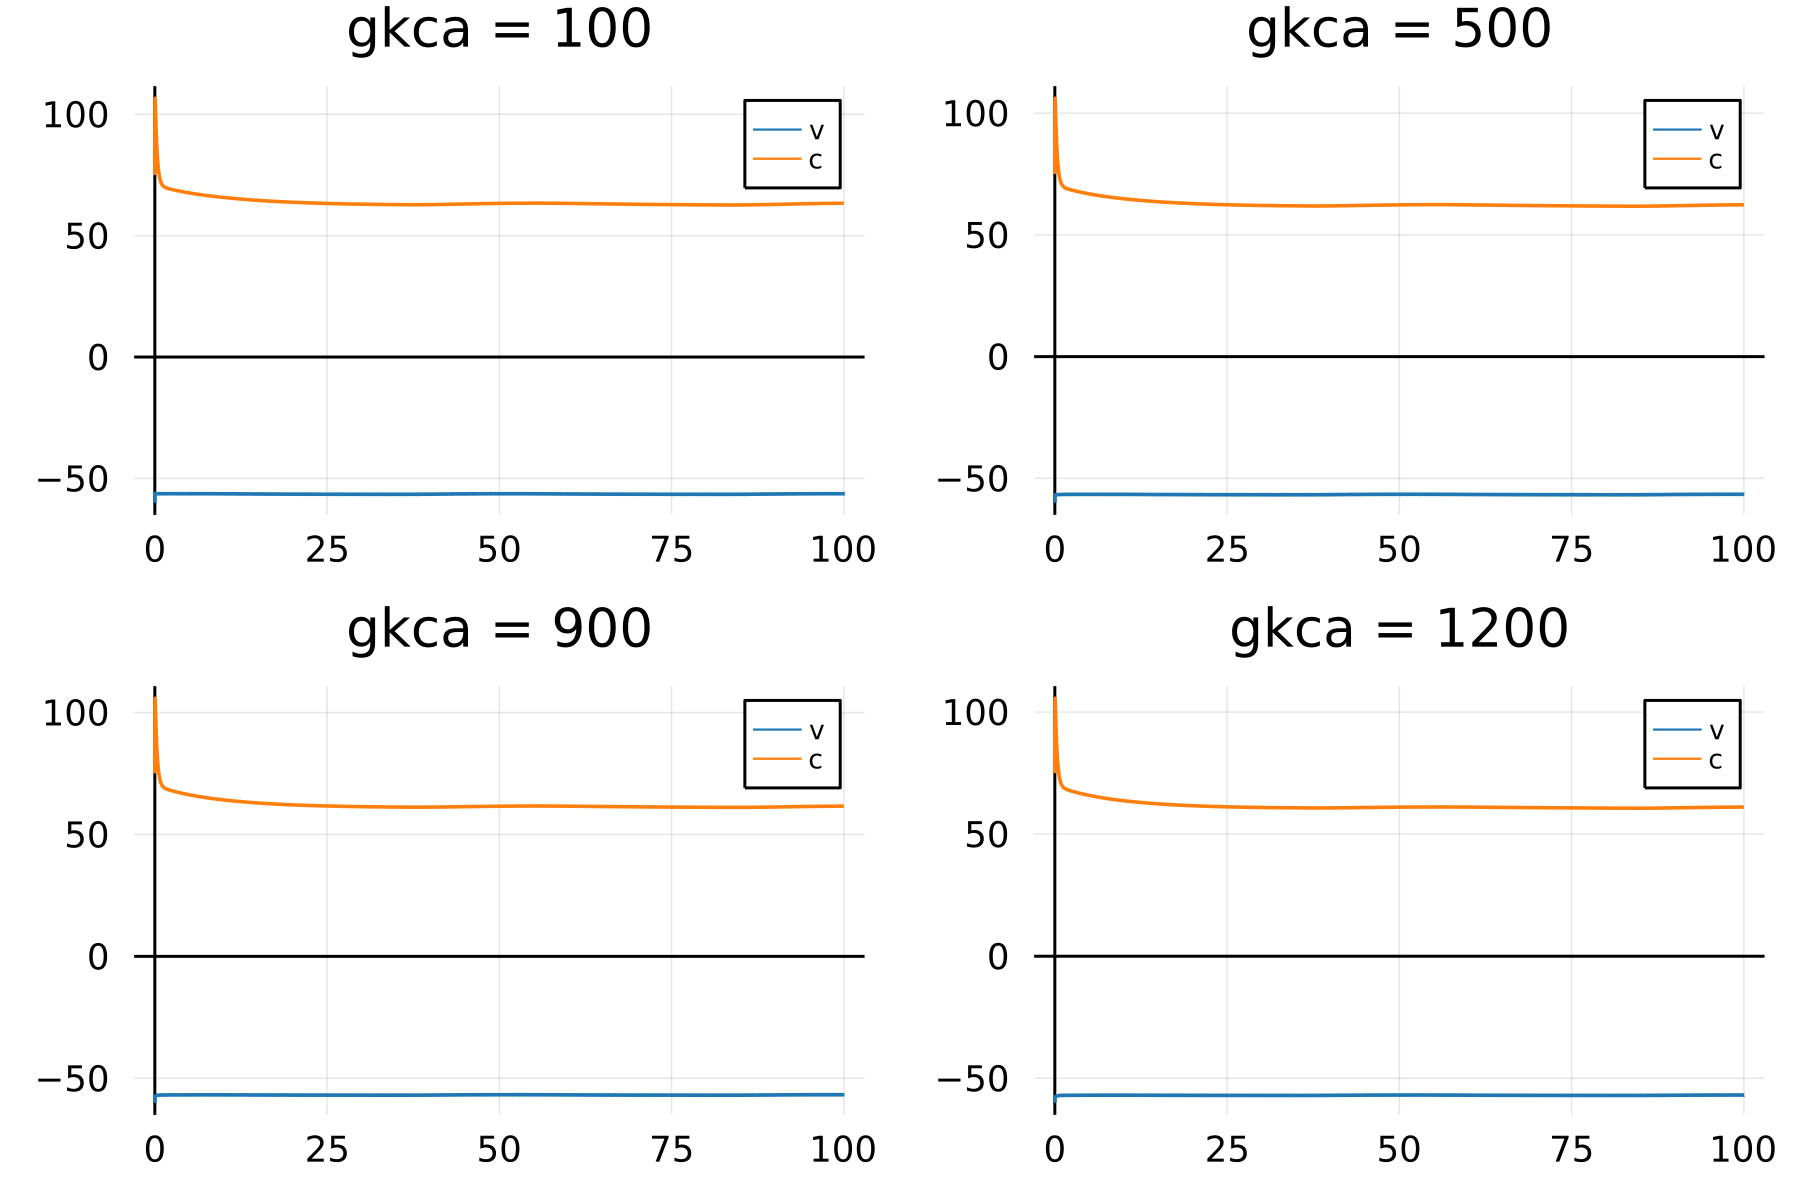

In [37]:
settings = (
    ode_func      = sys,
    y0            = y0,
    time          = 100 * 6000,
    plot_args     = Dict(),
    params        = reset_params(),
    plot_params   = [1,3],
    change_params = Dict(
           "vpdh" => 0.007,
        ),
);

_, _, plots, p = loopvals("gkca", [100, 500, 900, 1200], settings)

plot(p)

  2.477301 seconds (136.54 M allocations: 2.081 GiB, 20.30% gc time)
  3.541119 seconds (196.05 M allocations: 2.987 GiB, 18.15% gc time)
  3.679715 seconds (199.49 M allocations: 3.041 GiB, 19.21% gc time)
  3.756154 seconds (201.04 M allocations: 3.066 GiB, 18.82% gc time)


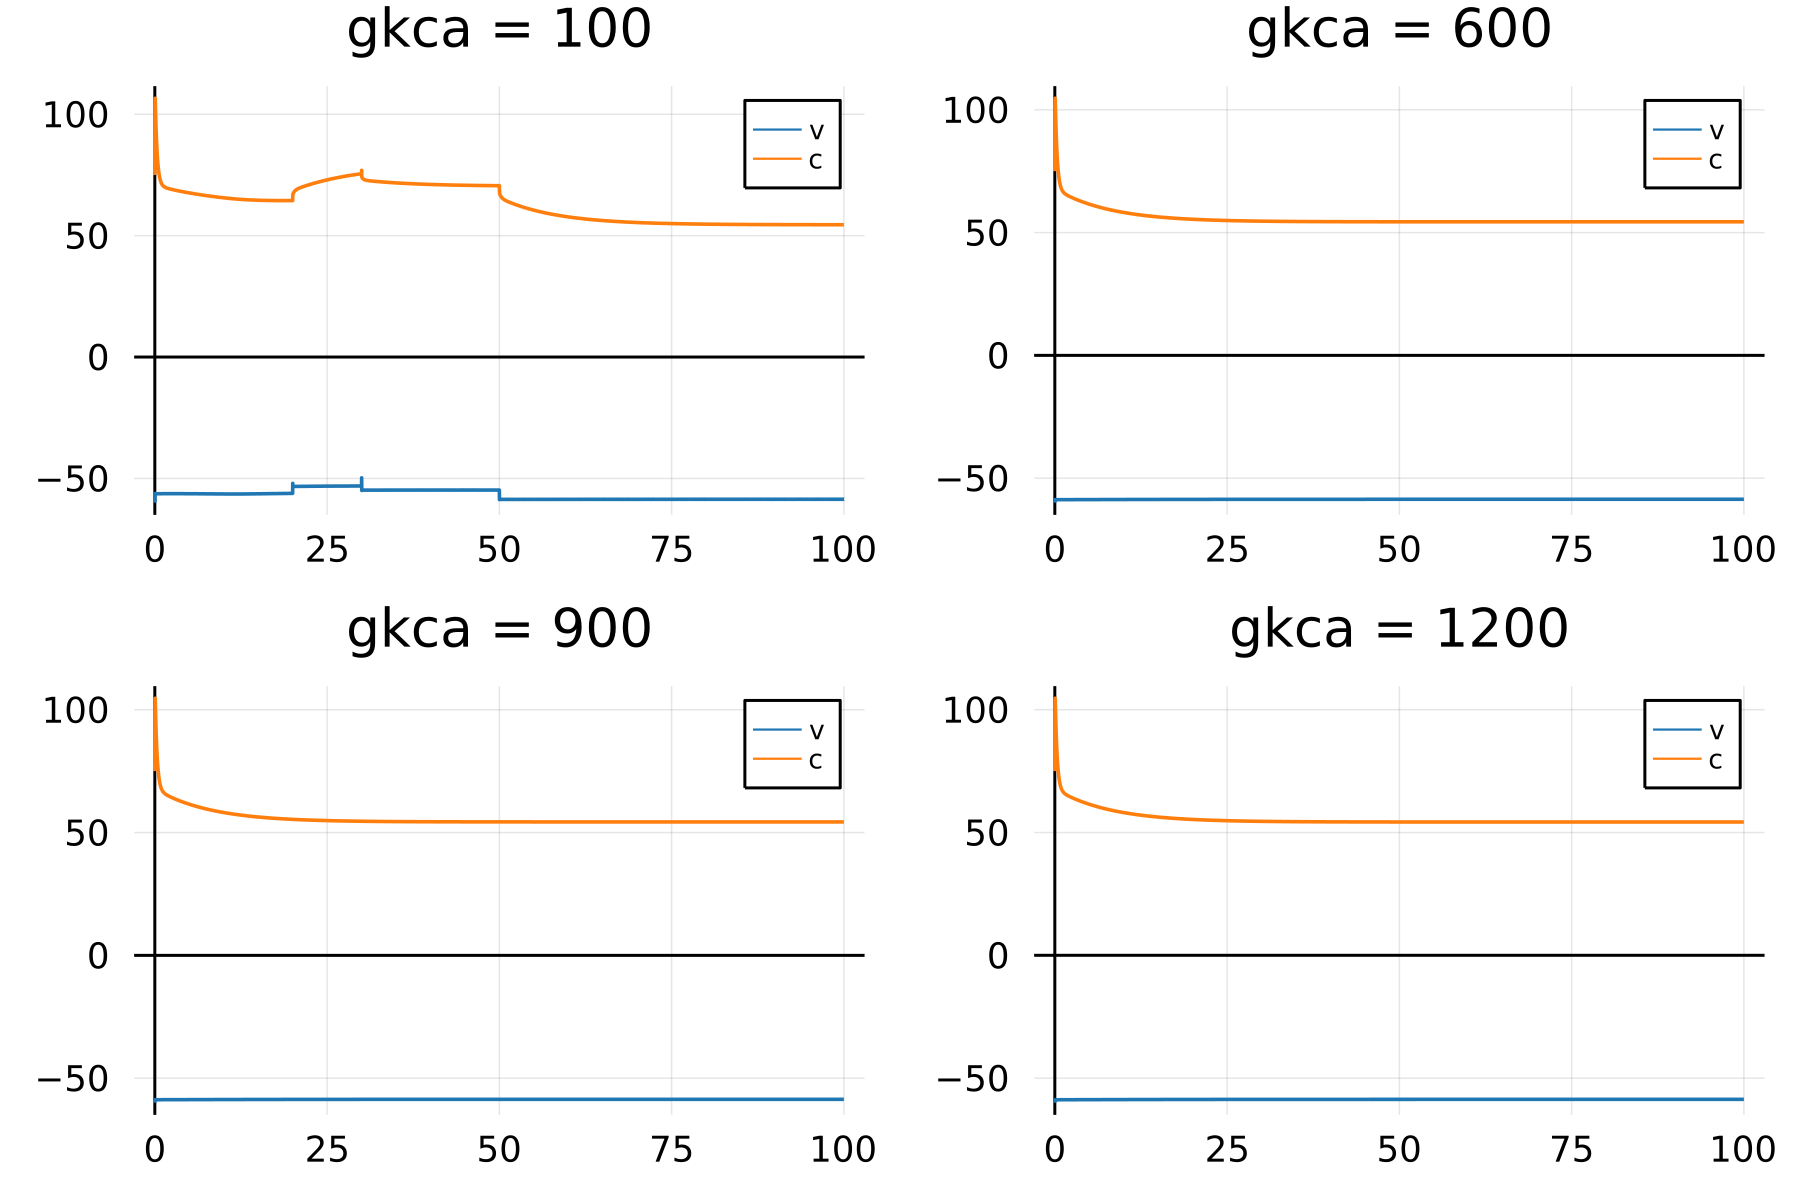

In [38]:
settings = (
    ode_func      = sys,
    y0            = y0,
    time          = 100 * 6000,
    plot_args     = Dict(),
    params        = reset_params(),
    plot_params   = [1,3],
    change_params = Dict(
           "vpdh" => 0.009,
        ),
    meds = [
        Med(10, "glucose", 40)
        Med(20, "KCl", 20)
        Med(30, "KCl", 40)
        Med(30, "Dz", 40)
        Med(50, "KCl", 0)
        ]
);

gkca = [100, 600, 900, 1200]
_, _, _, p = loopvals("gkca", gkca, settings)

#plot(sortedvalues(plots)..., dpi=300)
plot(p)

  2.629987 seconds (98.43 M allocations: 1.500 GiB, 12.24% gc time)
  2.694763 seconds (99.92 M allocations: 1.527 GiB, 11.94% gc time)


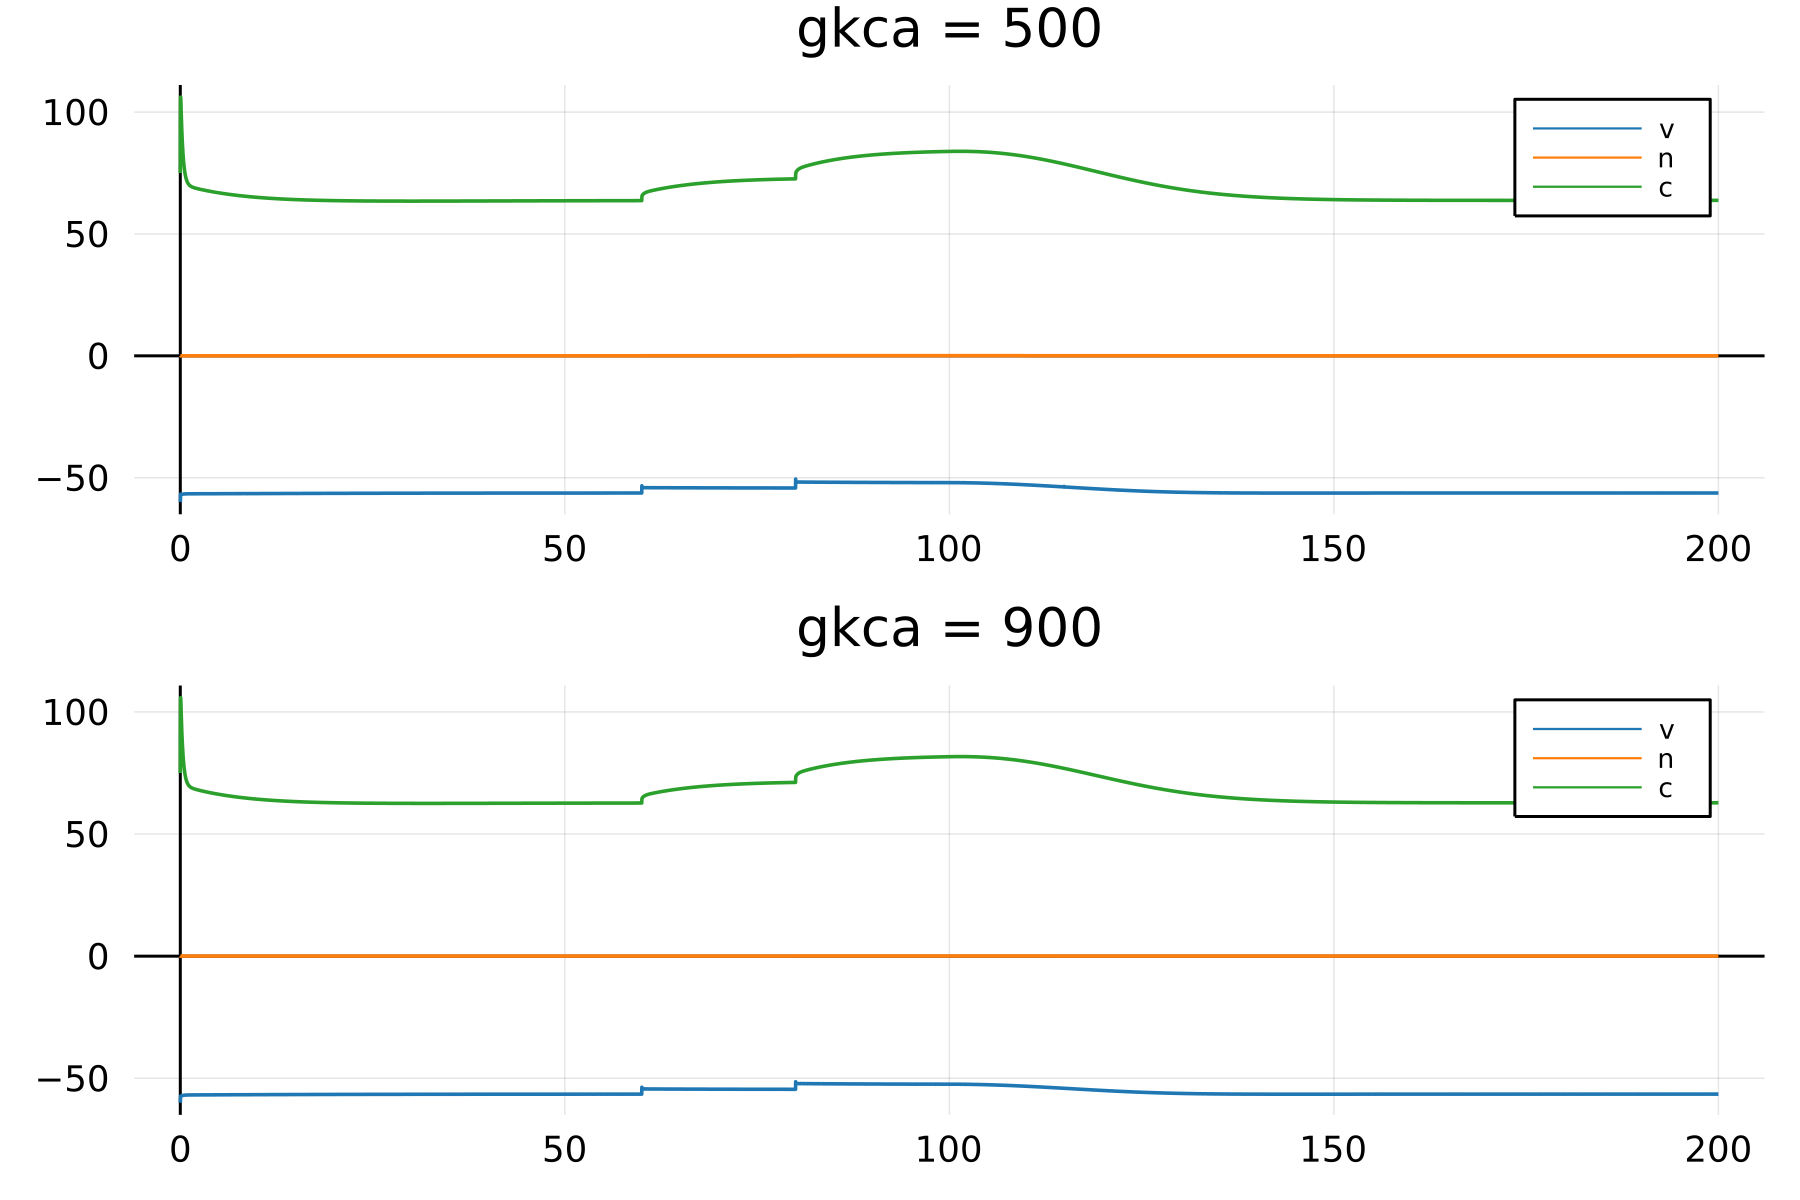

In [39]:
settings = (
    ode_func      = sys,
    y0            = y0,
    time          = 200 * 6000,
    plot_args     = Dict(),
    params        = reset_params(),
    plot_params   = [1,2,3],
    change_params = Dict(
           "vpdh" => 0.007,
        ),
    meds = [
        Med(0, "glucose", 5),
        Med(60, "KCl", 15),
        Med(80, "KCl", 40),
        ExpMed(100, "KCl", 40, 0.9999),
        ]
);

#settings.plot_args["layout"] = grid(2,1)
_, _, plots, p = loopvals("gkca", [500, 900], settings)

plot(sortedvalues(plots)..., dpi=300, layout = (length(plots),1)) #, title="")
#plot(p)

  4.163934 seconds (70.96 M allocations: 1.082 GiB, 6.10% gc time)


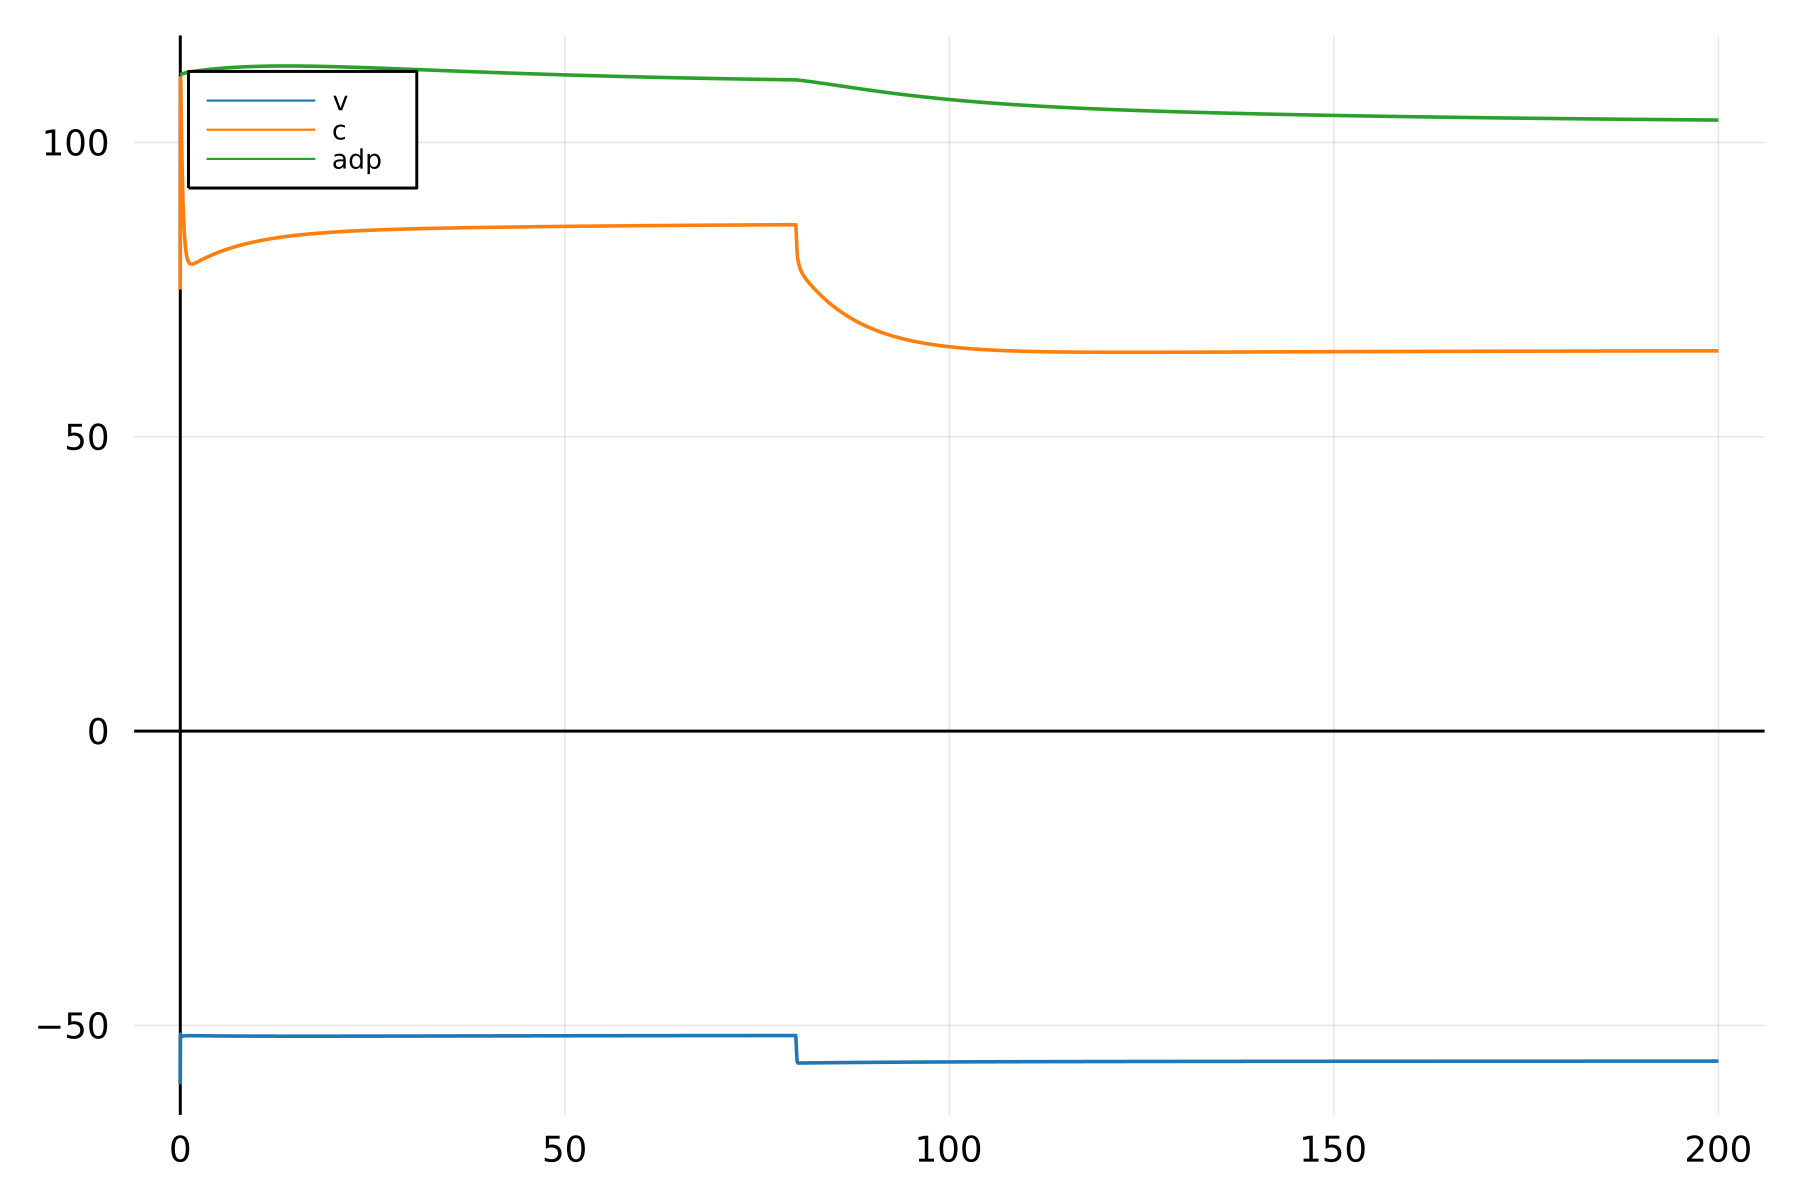

In [40]:
settings = (
    ode_func      = sys,
    y0            = y0,
    time          = 200 * 6000,
    plot_args     = Dict(),
    params        = reset_params(),
    plot_params   = [1,3,6],
    change_params = Dict(
           "vpdh" => 0.002,
           "gkca" => 200,
           "vpfk" => 0.20,
        ),
    meds = [
        Med(0, "glucose", 5),
        Med(40, "glucose", 500),
        Med(50, "glucose", 5),
        Med(10, "KCl", 15),
        Med(20, "KCl", 0),
        Med(70, "KCl", 40),
        ExpMed(80, "KCl", 40, 0.1),
        ]
);

plot(simulate(settings)[3], legend = :topleft)

  3.654777 seconds (64.31 M allocations: 1003.428 MiB, 5.63% gc time)


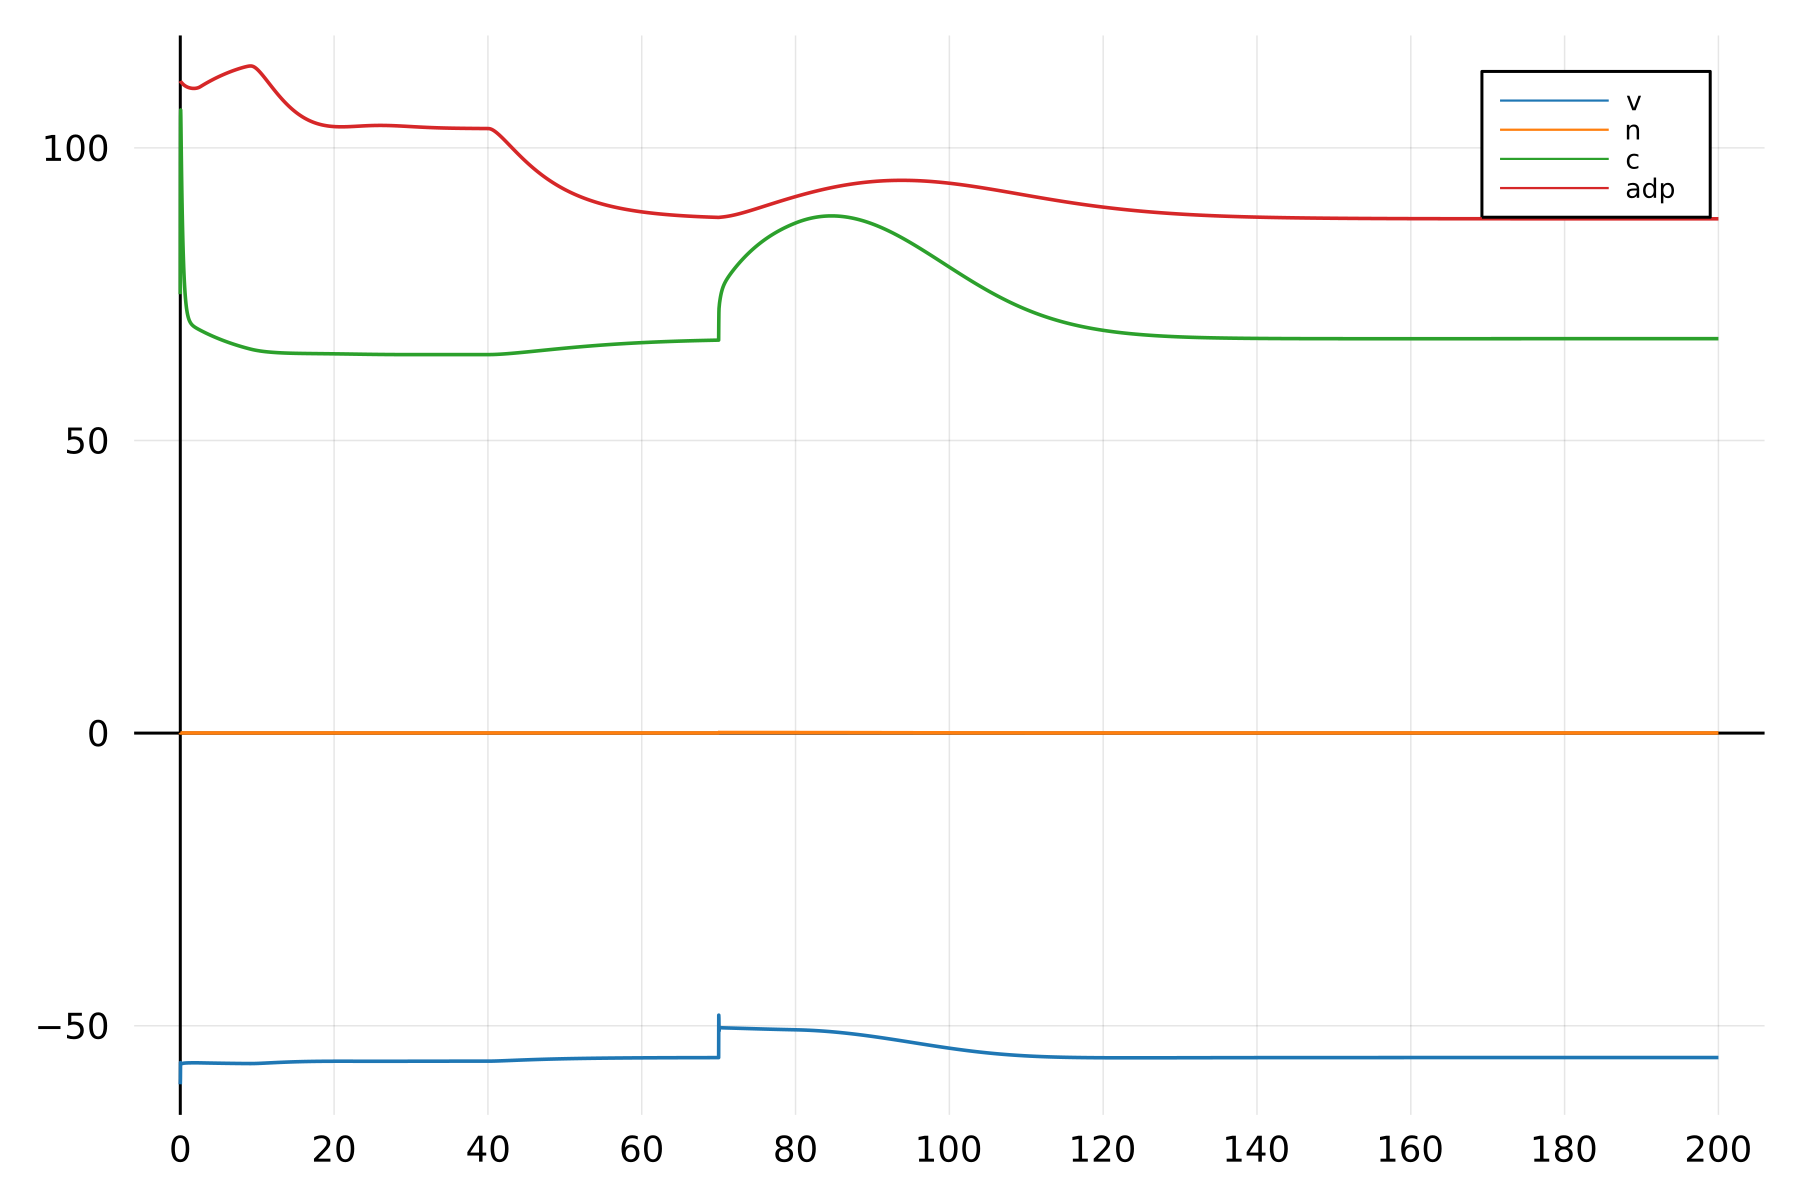

In [41]:
settings = (
    ode_func      = sys,
    y0            = y0,
    time          = 200 * 6000,
    plot_args     = Dict(),
    params        = reset_params(),
    plot_params   = [1,2,3,6],
    change_params = Dict(
           "vpdh" => 0.02,
           "gkca" => 200,
           "vpfk" => 0.020,
        ),
    meds = [
        Med(0, "glucose", 5),
        Med(40, "glucose", 500),
        Med(50, "glucose", 5),
        Med(10, "KCl", 15),
        Med(20, "KCl", 0),
        Med(70, "KCl", 40),
        ExpMed(80, "KCl", 40, 0.9999),
        ]
);

plot(simulate(settings)[3], xticks = 0:20:200)

  0.279201 seconds (17.29 M allocations: 269.525 MiB)
  0.352824 seconds (20.36 M allocations: 317.841 MiB)
  0.428865 seconds (21.07 M allocations: 329.613 MiB, 10.90% gc time)


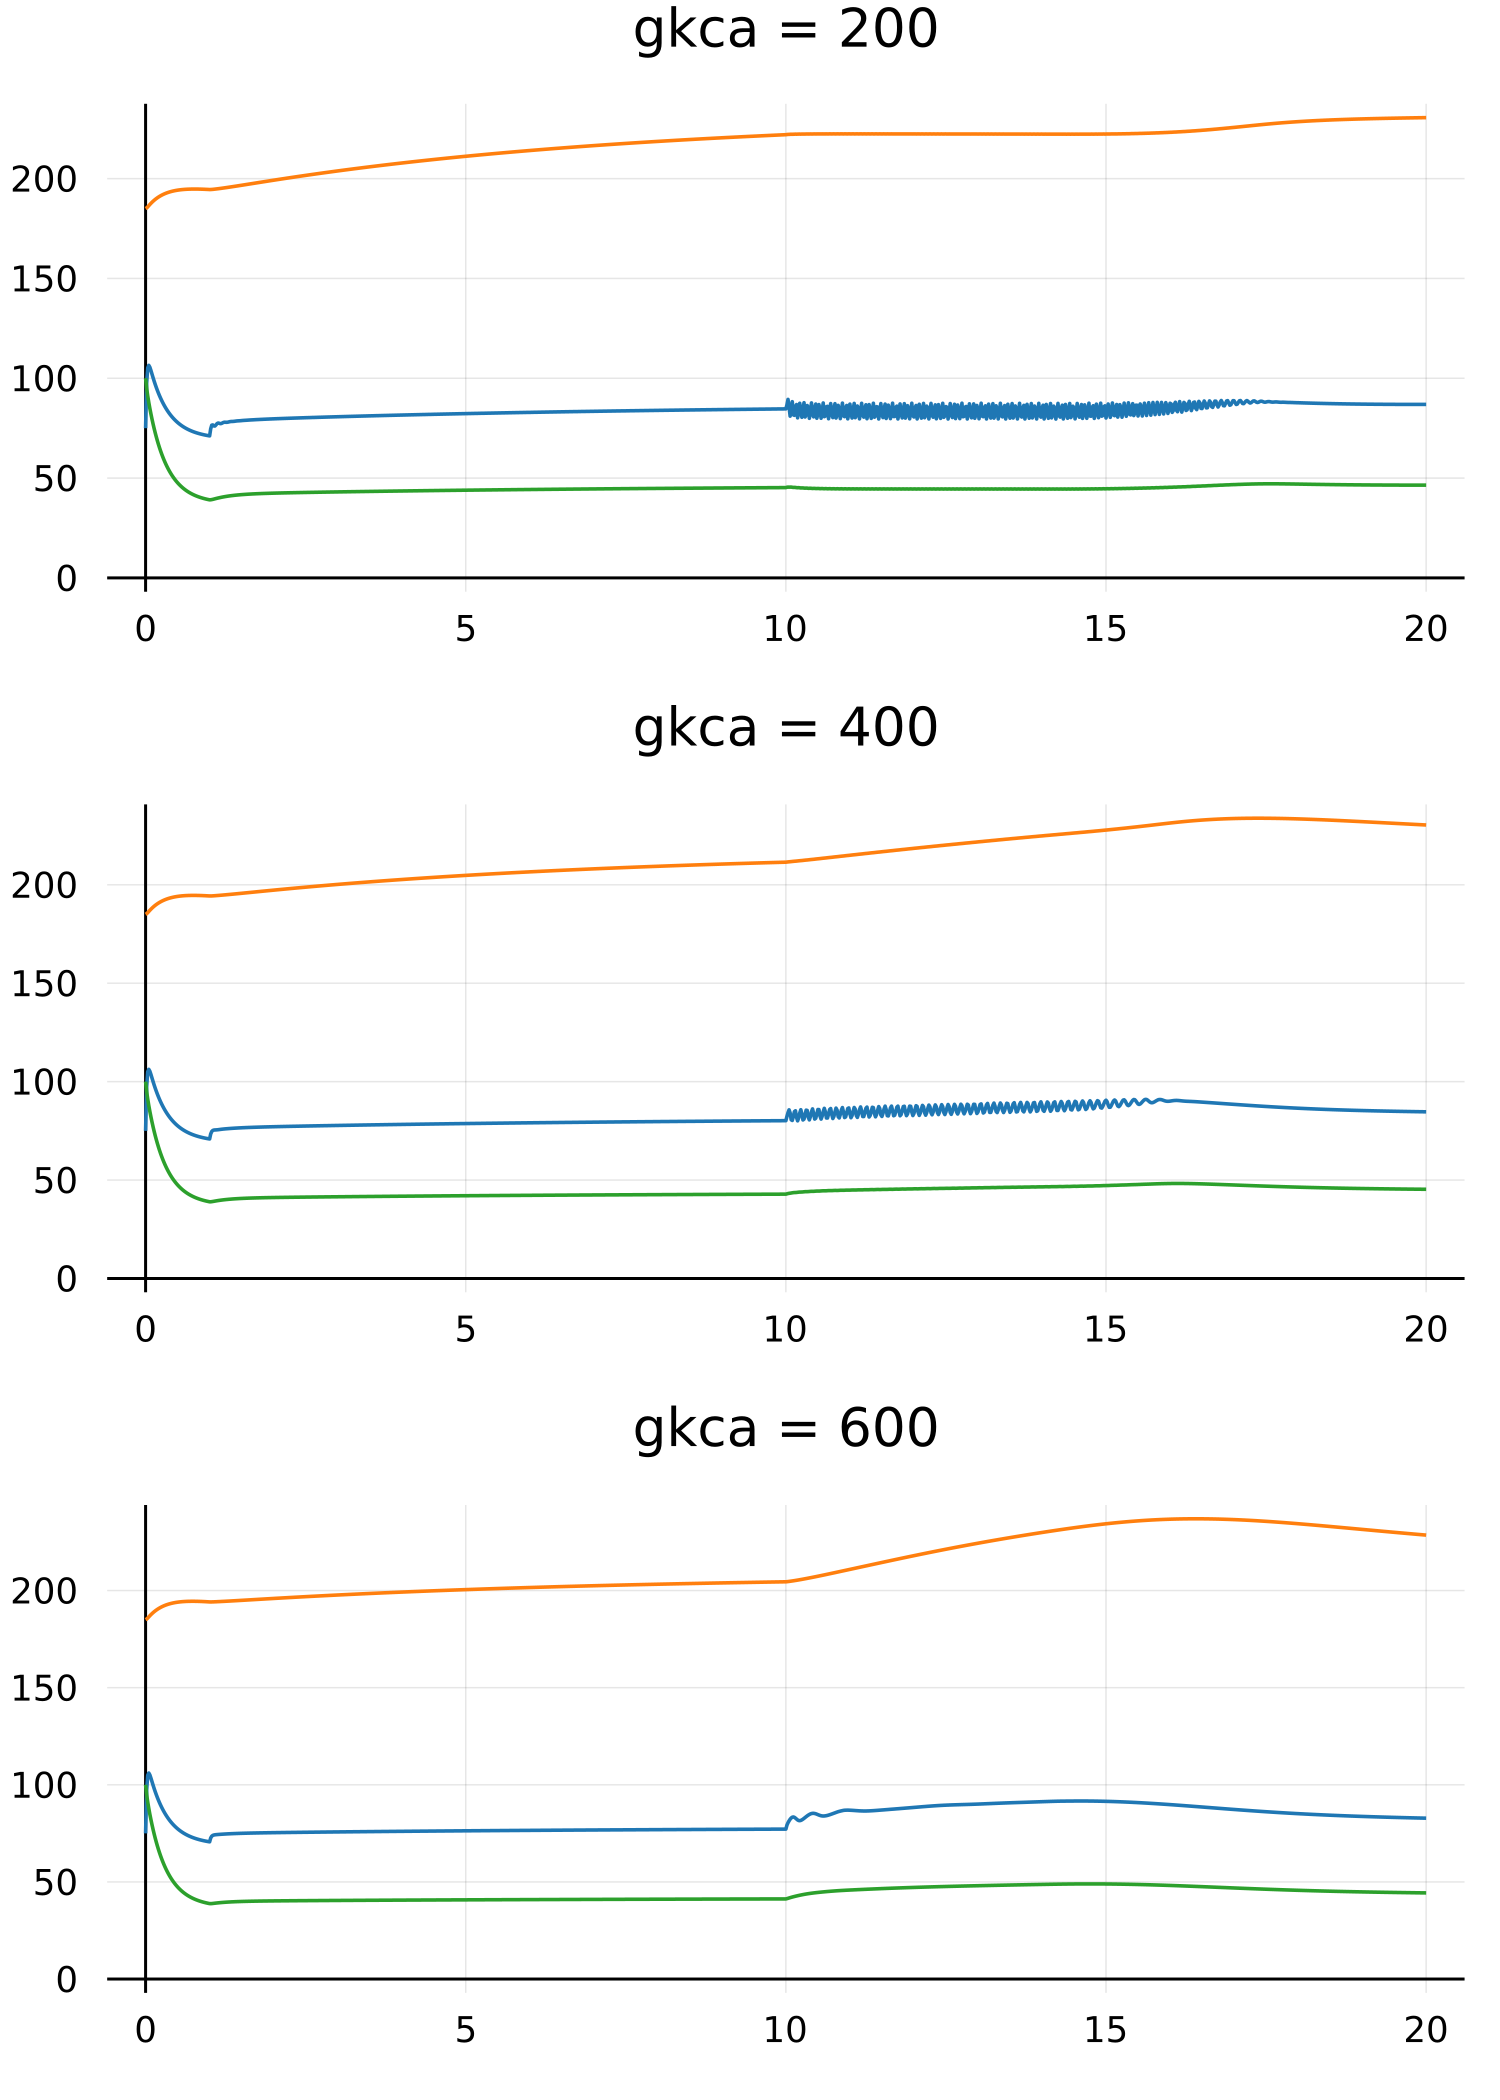

In [42]:
settings = (
    ode_func      = sys,
    y0            = y0,
    time          = 20 * 6000,
    plot_args     = Dict(),
    params        = reset_params(),
    plot_params   = [3,4,5],
    change_params = Dict(
           "vpdh" => 0.002,
           "Jgk" => 0.01,
        ),
    meds = [
        Med(1, "tolbutamid", 10),
        Med(10, "KCl", 30),
        ExpMed(14, "KCl", 30, 0.995),
        ]
);

_, _, plots, p = loopvals("gkca", [200, 400, 600], settings)

#plot(p)
plot(sortedvalues(plots)...,
    dpi=300,
    layout =  (
        length(plots),
        1
    ),
    legend=false,
    size = (500,700)
)

Dict{String, Vector{Any}}("gkatpbar" => [], "t" => [], "vk" => [])
  1.739090 seconds (42.62 M allocations: 662.616 MiB, 9.37% gc time)


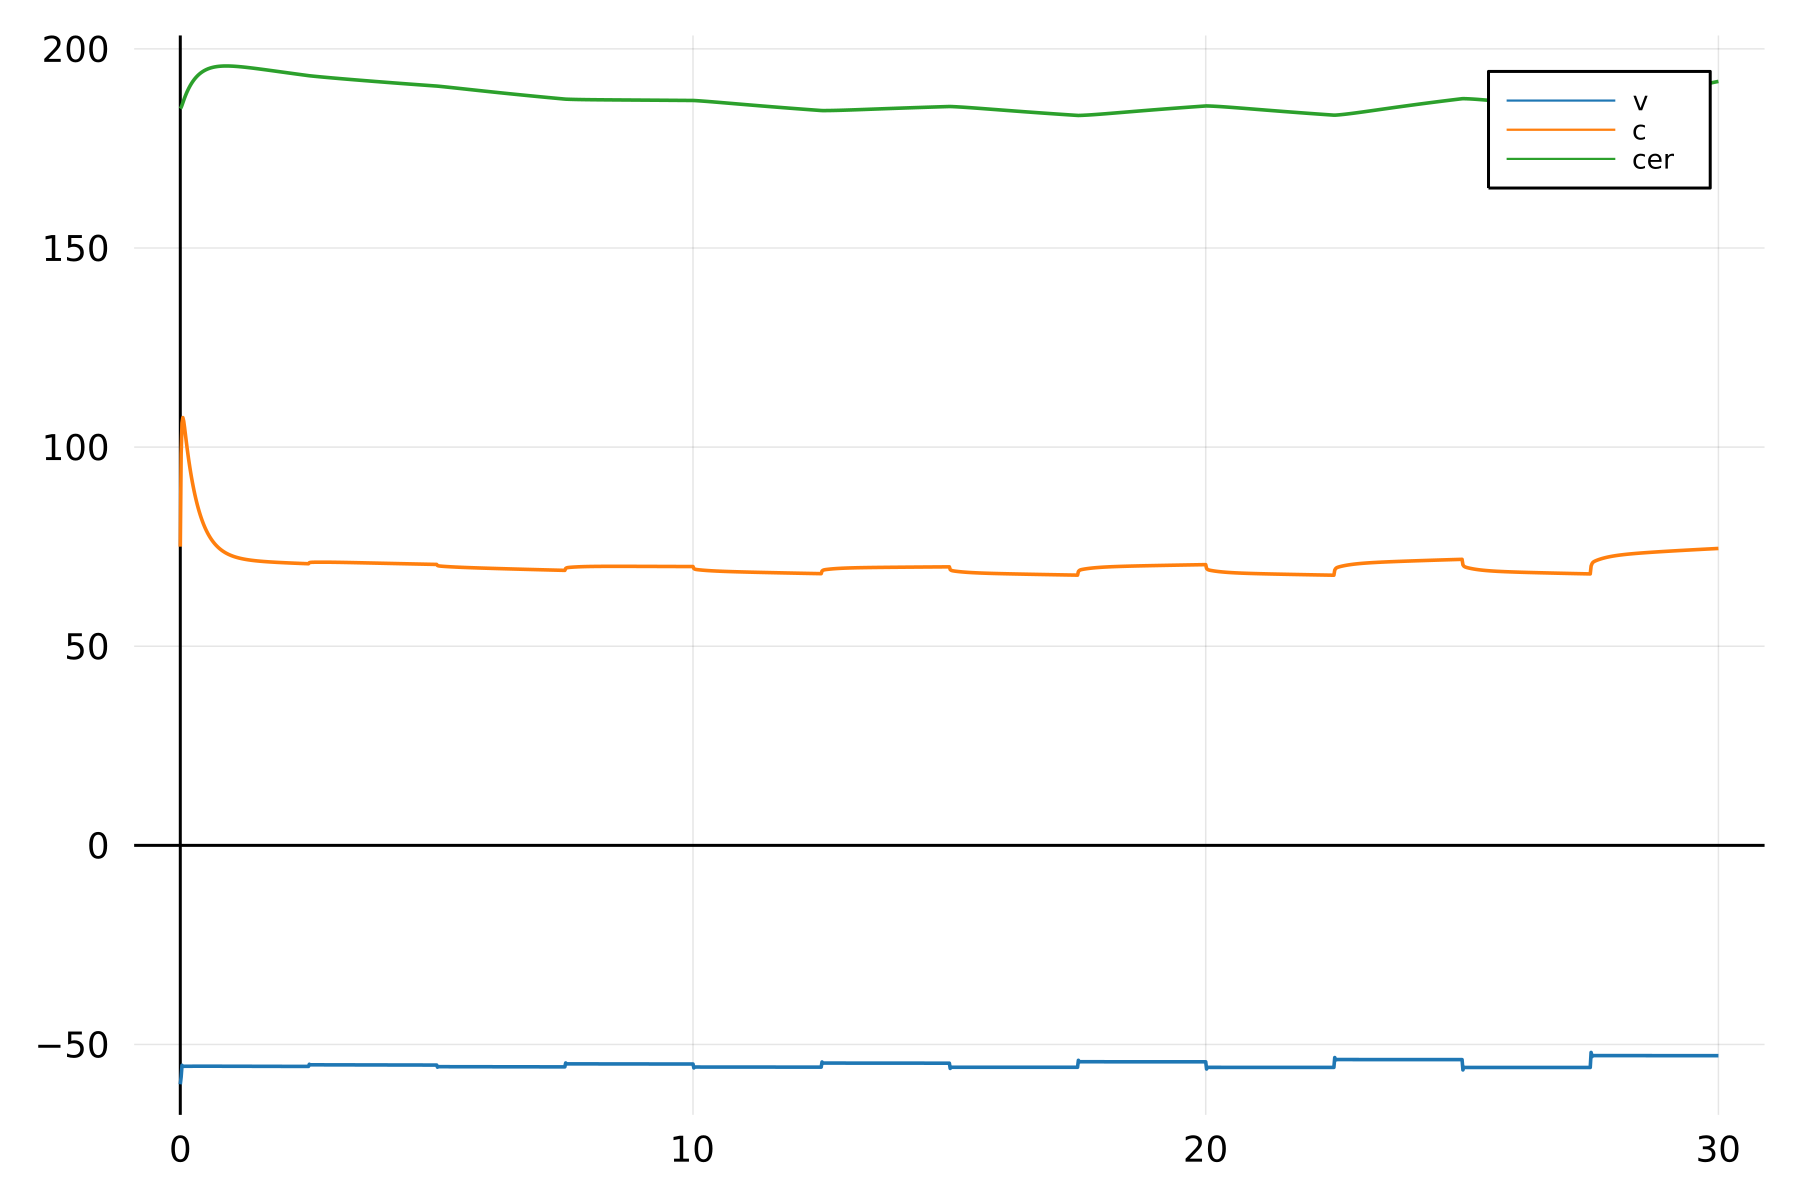

In [43]:
settings = (
    ode_func      = sys,
    y0            = y0,
    time          = 30 * 6000,
    plot_args     = Dict(),
    params        = reset_params(),
    plot_params   = [1,3,4],
    change_params = Dict(
           "vpdh" => 0.15,
           "Jgk" => 0.002,
        ),
    meds = [
        Med(0,    "KCl", 4.8),
        Med(5,    "KCl", 4.8),
        Med(10,   "KCl", 4.8),
        Med(15,   "KCl", 4.8),
        Med(20,   "KCl", 4.8),
        Med(25,   "KCl", 4.8),
        
        Med(2.5,  "KCl", 7.5),
        Med(7.5,  "KCl", 10),
        Med(12.5, "KCl", 12),
        Med(17.5, "KCl", 15),
        Med(22.5, "KCl", 20),
        Med(27.5, "KCl", 30),
        ]
);

global stats = Dict(
    "t" => [],
    "vk" => [],
    "gkatpbar" => [],
    )
println(stats)
#_, _, plots, p = loopvals("gkca", [200, 400, 600], settings)
#s, sm, plots, p = loopvals("k_ext", [10, 20, 30, 50], settings)
s,sm,p = simulate(settings)

plot(p)

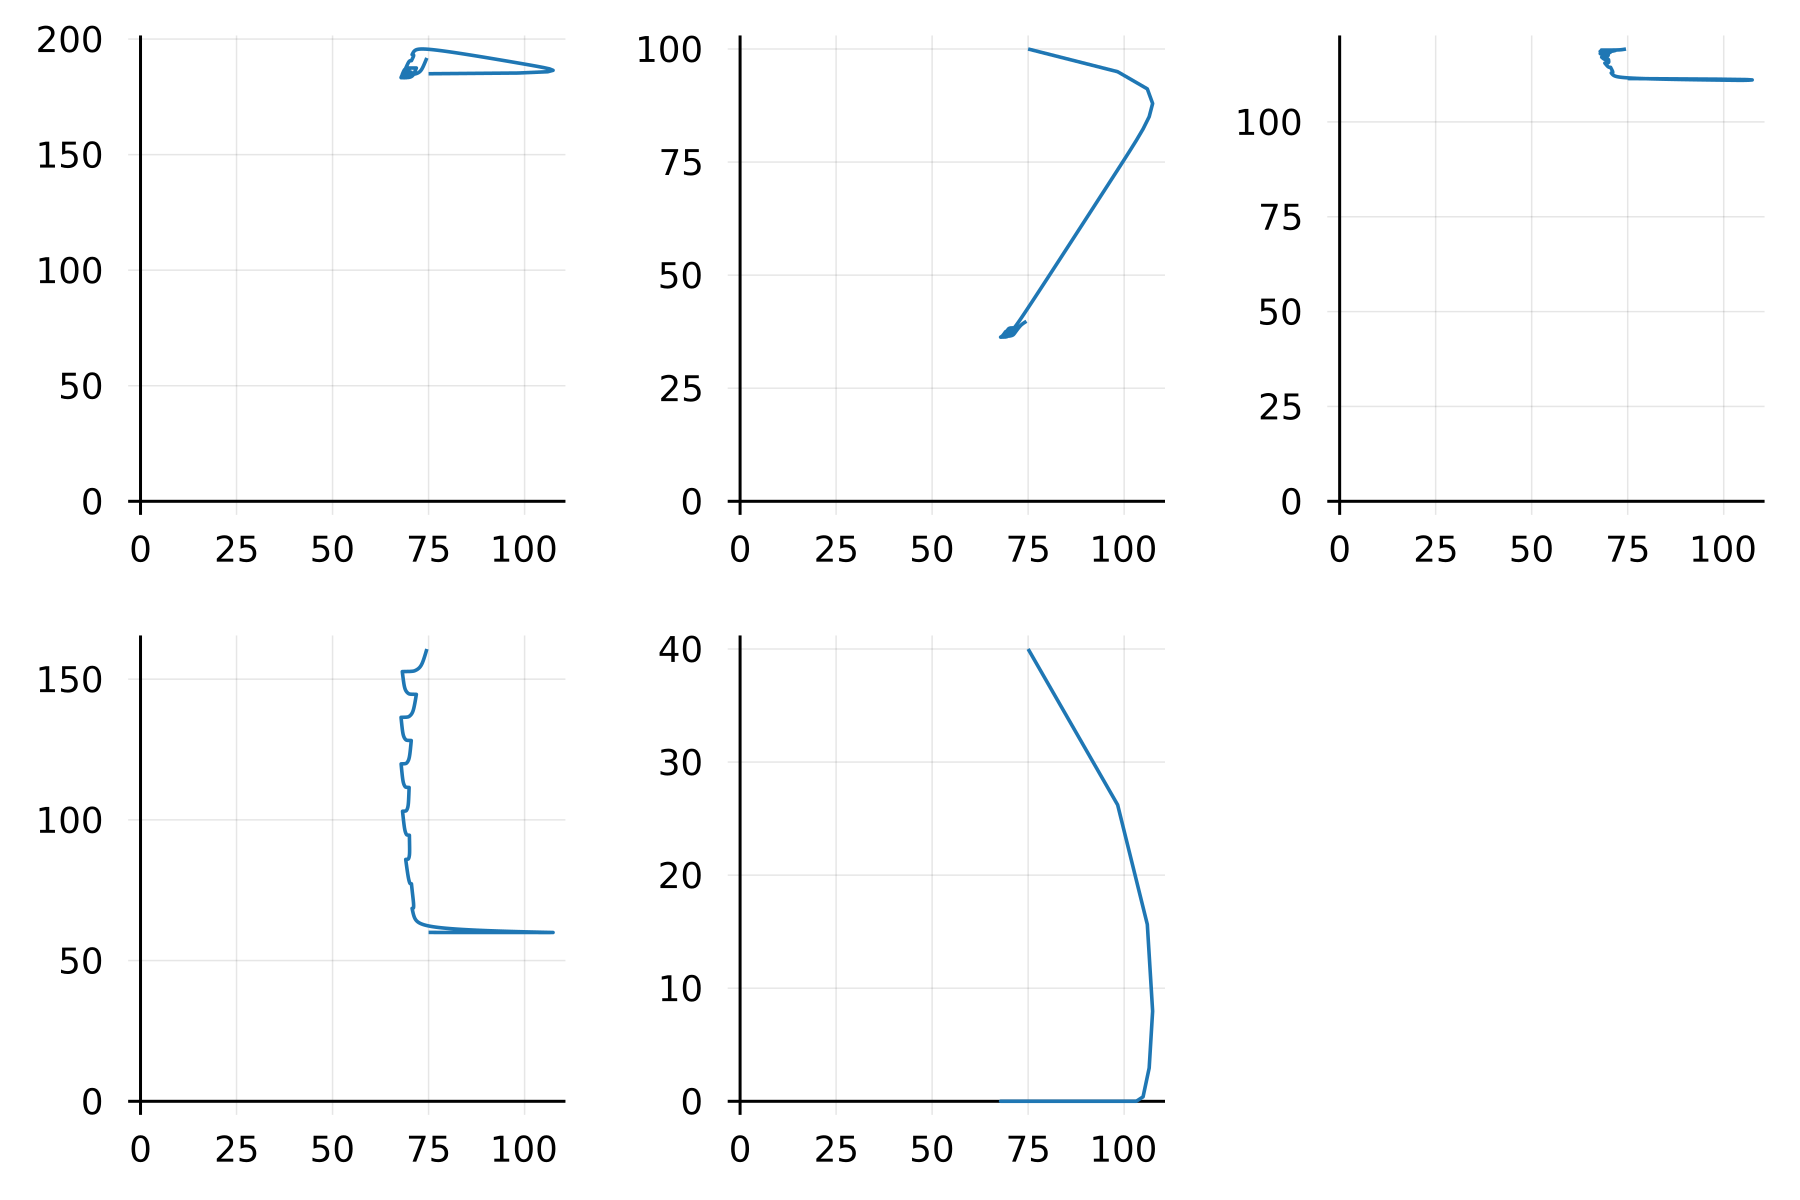

In [44]:
plot(
plot(sm[:,3] ,sm[:,4]),
plot(sm[:,3] ,sm[:,5]),
plot(sm[:,3] ,sm[:,6]),
plot(sm[:,3] ,sm[:,7]),
plot(sm[:,3] ,sm[:,8]),
    legend = false,
    )

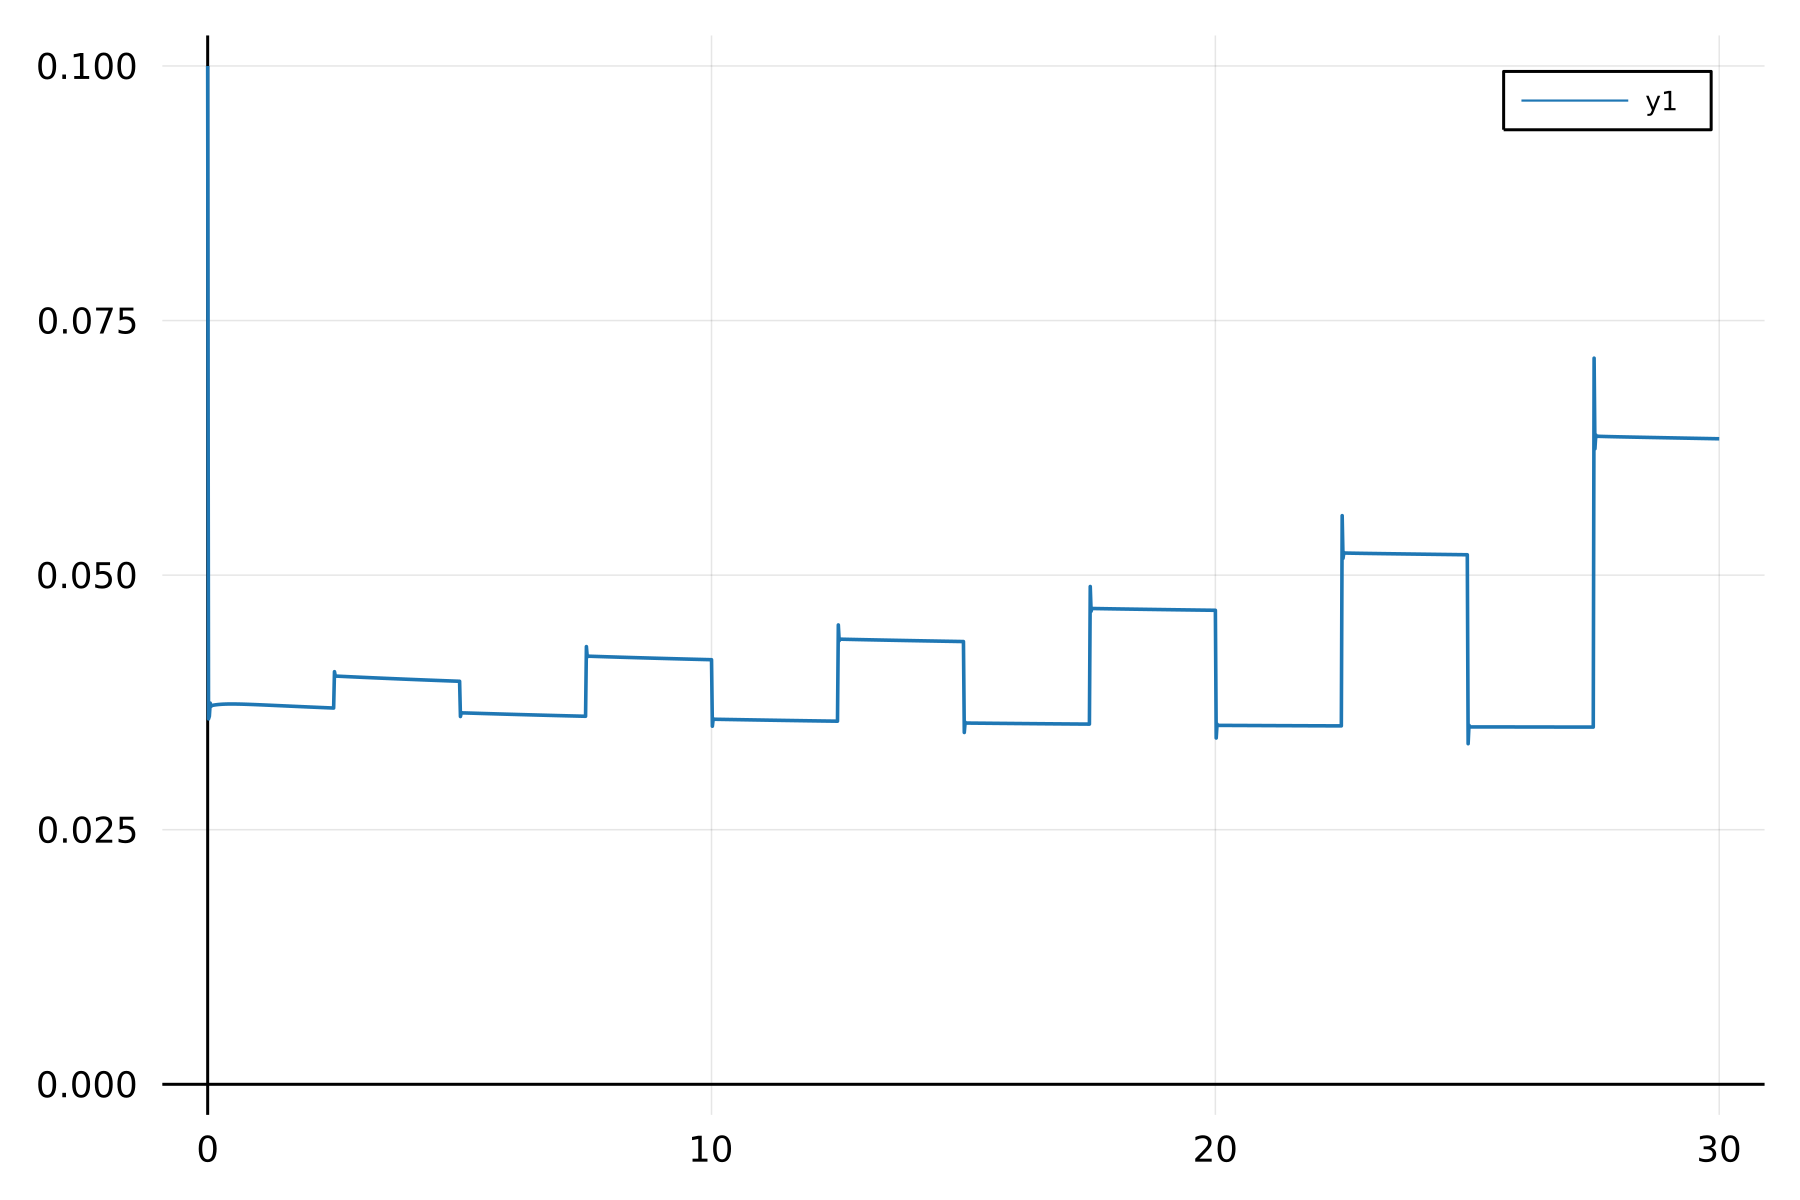

In [45]:
plot(
    s.t/6000,
    #stats["vk"],
    sm[:,2],
)

In [46]:
doses = 10 .+ [7.5 10 12 15 20 30]
map(x -> vk(x), doses)

LoadError: MethodError: objects of type Vector{Int64} are not callable
Use square brackets [] for indexing an Array.

In [47]:
push!(stats["kv"], 29)

LoadError: KeyError: key "kv" not found

  2.395682 seconds (162.62 M allocations: 2.496 GiB, 24.99% gc time)
  2.466111 seconds (168.13 M allocations: 2.582 GiB, 24.28% gc time)
  2.517767 seconds (170.81 M allocations: 2.623 GiB, 23.78% gc time)
  2.532531 seconds (171.23 M allocations: 2.634 GiB, 23.64% gc time)


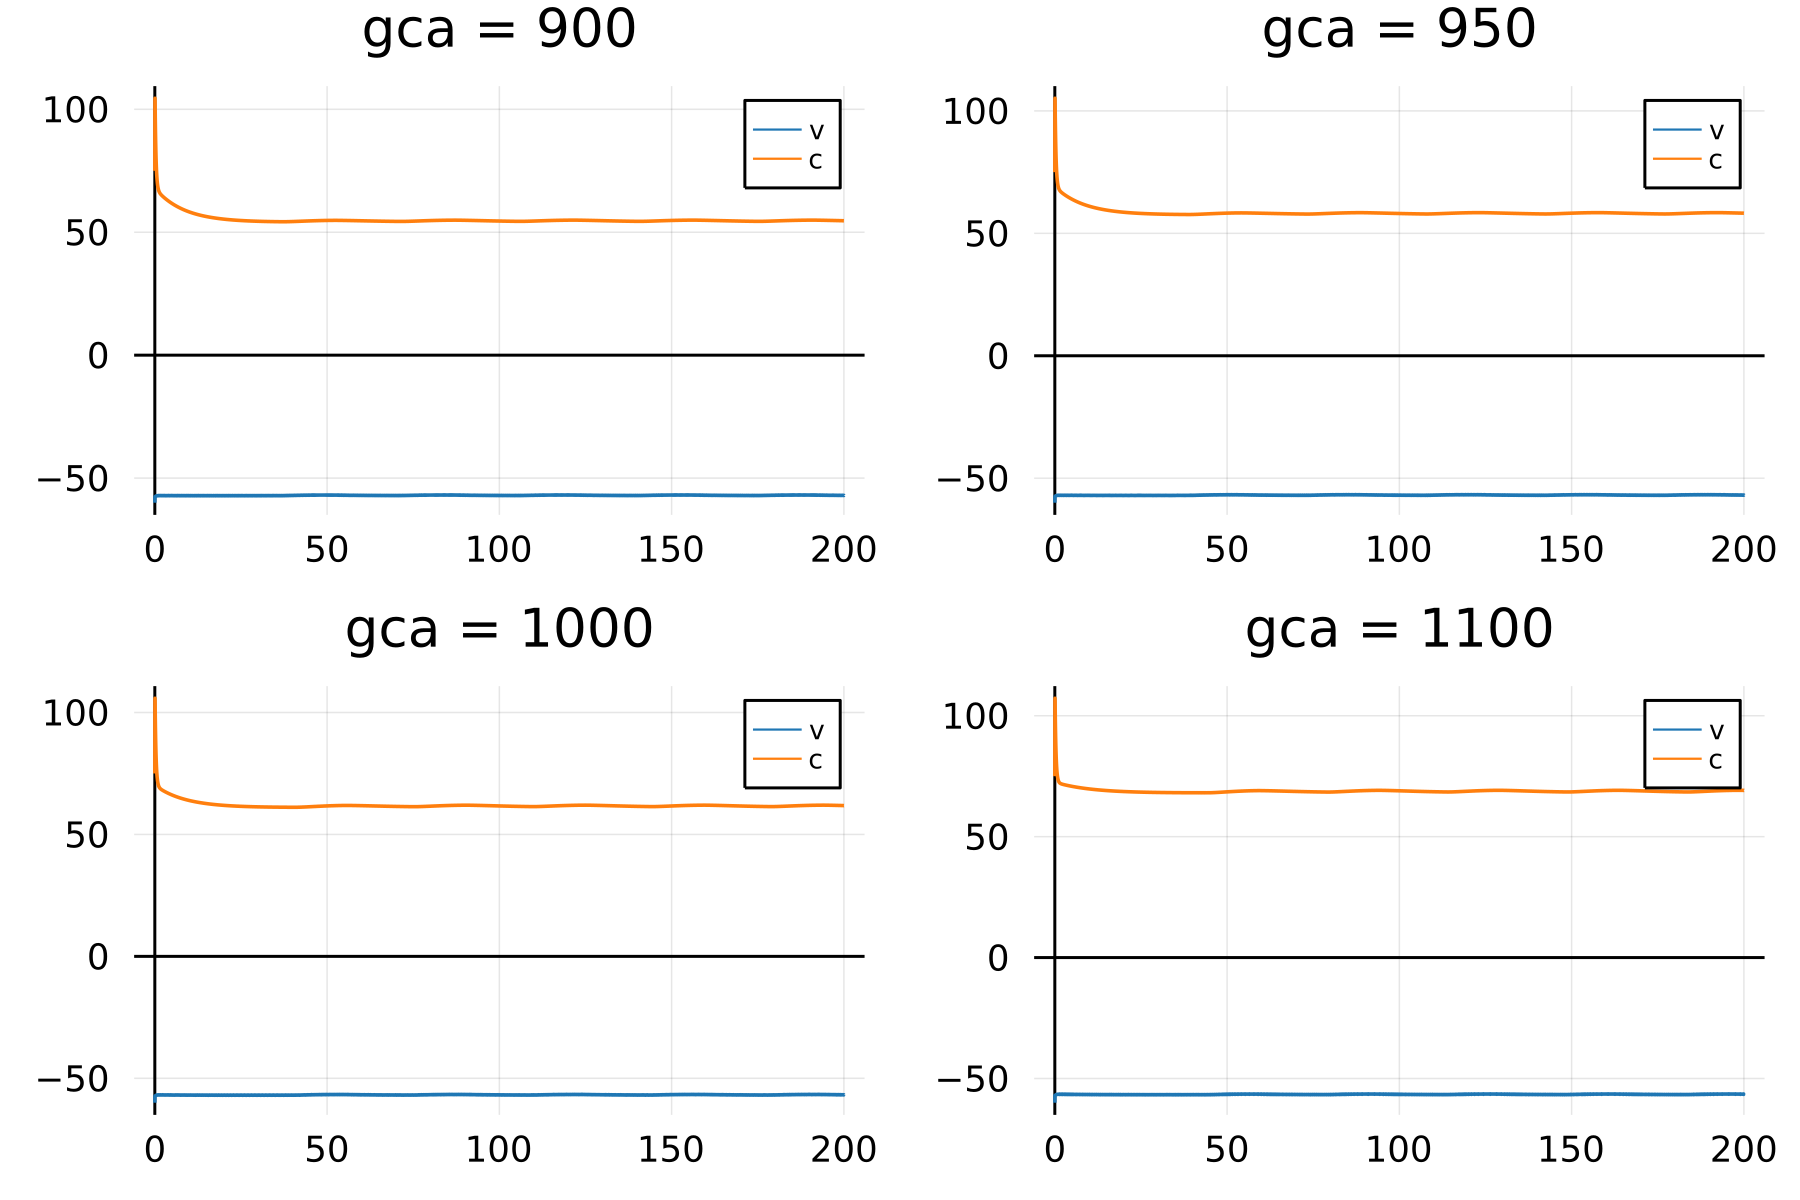

In [48]:
settings = (
    ode_func      = sys,
    y0            = y0,
    time          = 200 * 6000,
    plot_args     = Dict(),
    params        = reset_params(),
    plot_params   = [1,3],
    change_params = Dict(
           "vpdh" => 0.02,
           "Jgk"  => 0.0019,
           "gkca" => 900,
        ),
);

gca = [900, 950, 1000, 1100]
_, _, _, p = loopvals("gca", gca, settings)

#plot(sortedvalues(plots)..., dpi=300)
plot(p)

  2.220778 seconds (158.91 M allocations: 2.440 GiB, 22.38% gc time)
  2.255585 seconds (161.65 M allocations: 2.484 GiB, 22.03% gc time)
  2.456126 seconds (166.62 M allocations: 2.564 GiB, 24.50% gc time)
  2.463214 seconds (166.78 M allocations: 2.569 GiB, 24.43% gc time)


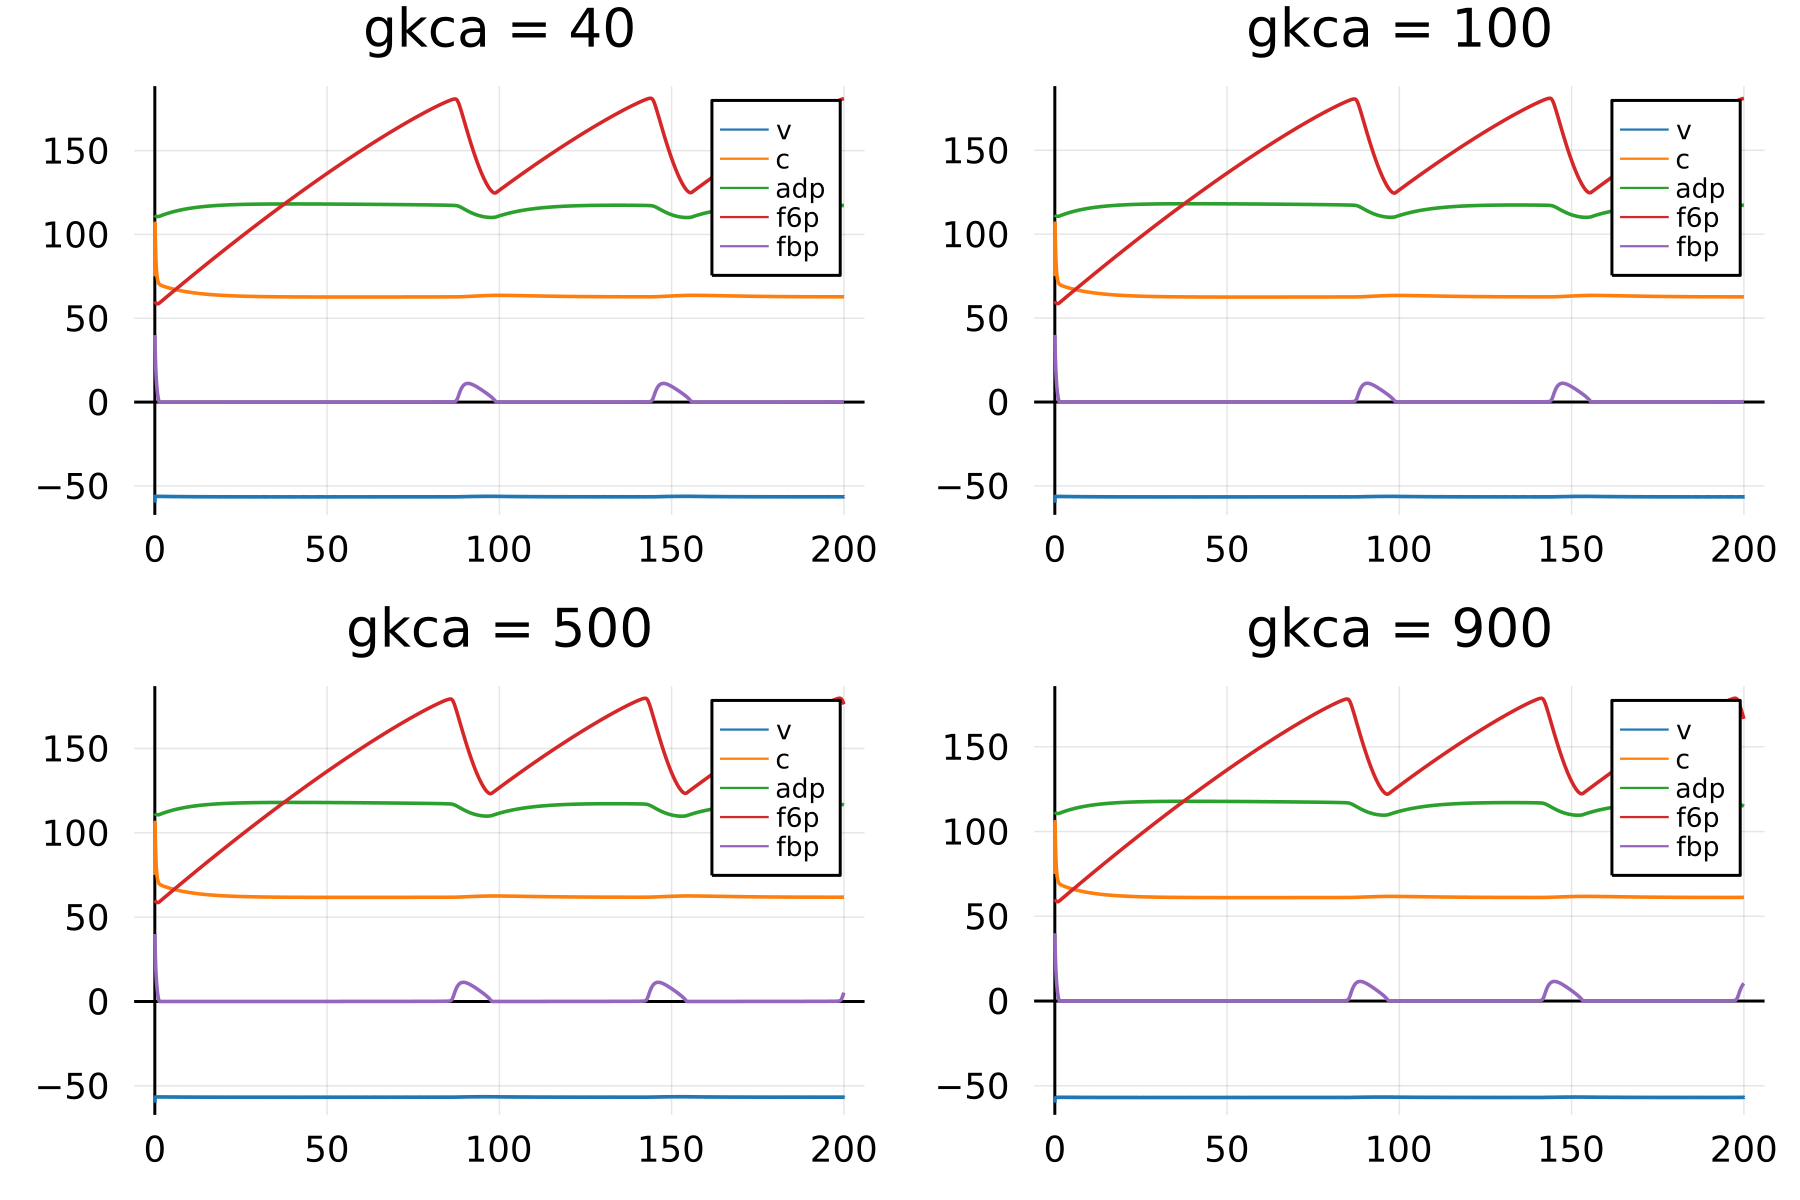

In [49]:
settings = (
    ode_func      = sys,
    y0            = y0,
    time          = 200 * 6000,
    plot_args     = Dict(),
    params        = reset_params(),
    plot_params   = [1,3,6,7,8],
    change_params = Dict(
           "vpdh" => 0.02,
           "Jgk"  => 0.001,
        ),
);

_, _, plots, p = loopvals("gkca", [40, 100, 500, 900], settings)

#plot(sortedvalues(plots)..., dpi=300, label=["V" "C" "V" "C" "V" "C" "V" "C"])
plot(p)

In [50]:
s.t

3600-element Vector{Float64}:
      0.0
    100.0
    100.0
    200.0
    200.0
    300.0
    300.0
    400.0
    400.0
    500.0
    500.0
    600.0
    600.0
      ⋮
 179400.0
 179500.0
 179500.0
 179600.0
 179600.0
 179700.0
 179700.0
 179800.0
 179800.0
 179900.0
 179900.0
 180000.0

  1.987038 seconds (48.86 M allocations: 763.171 MiB, 10.46% gc time)


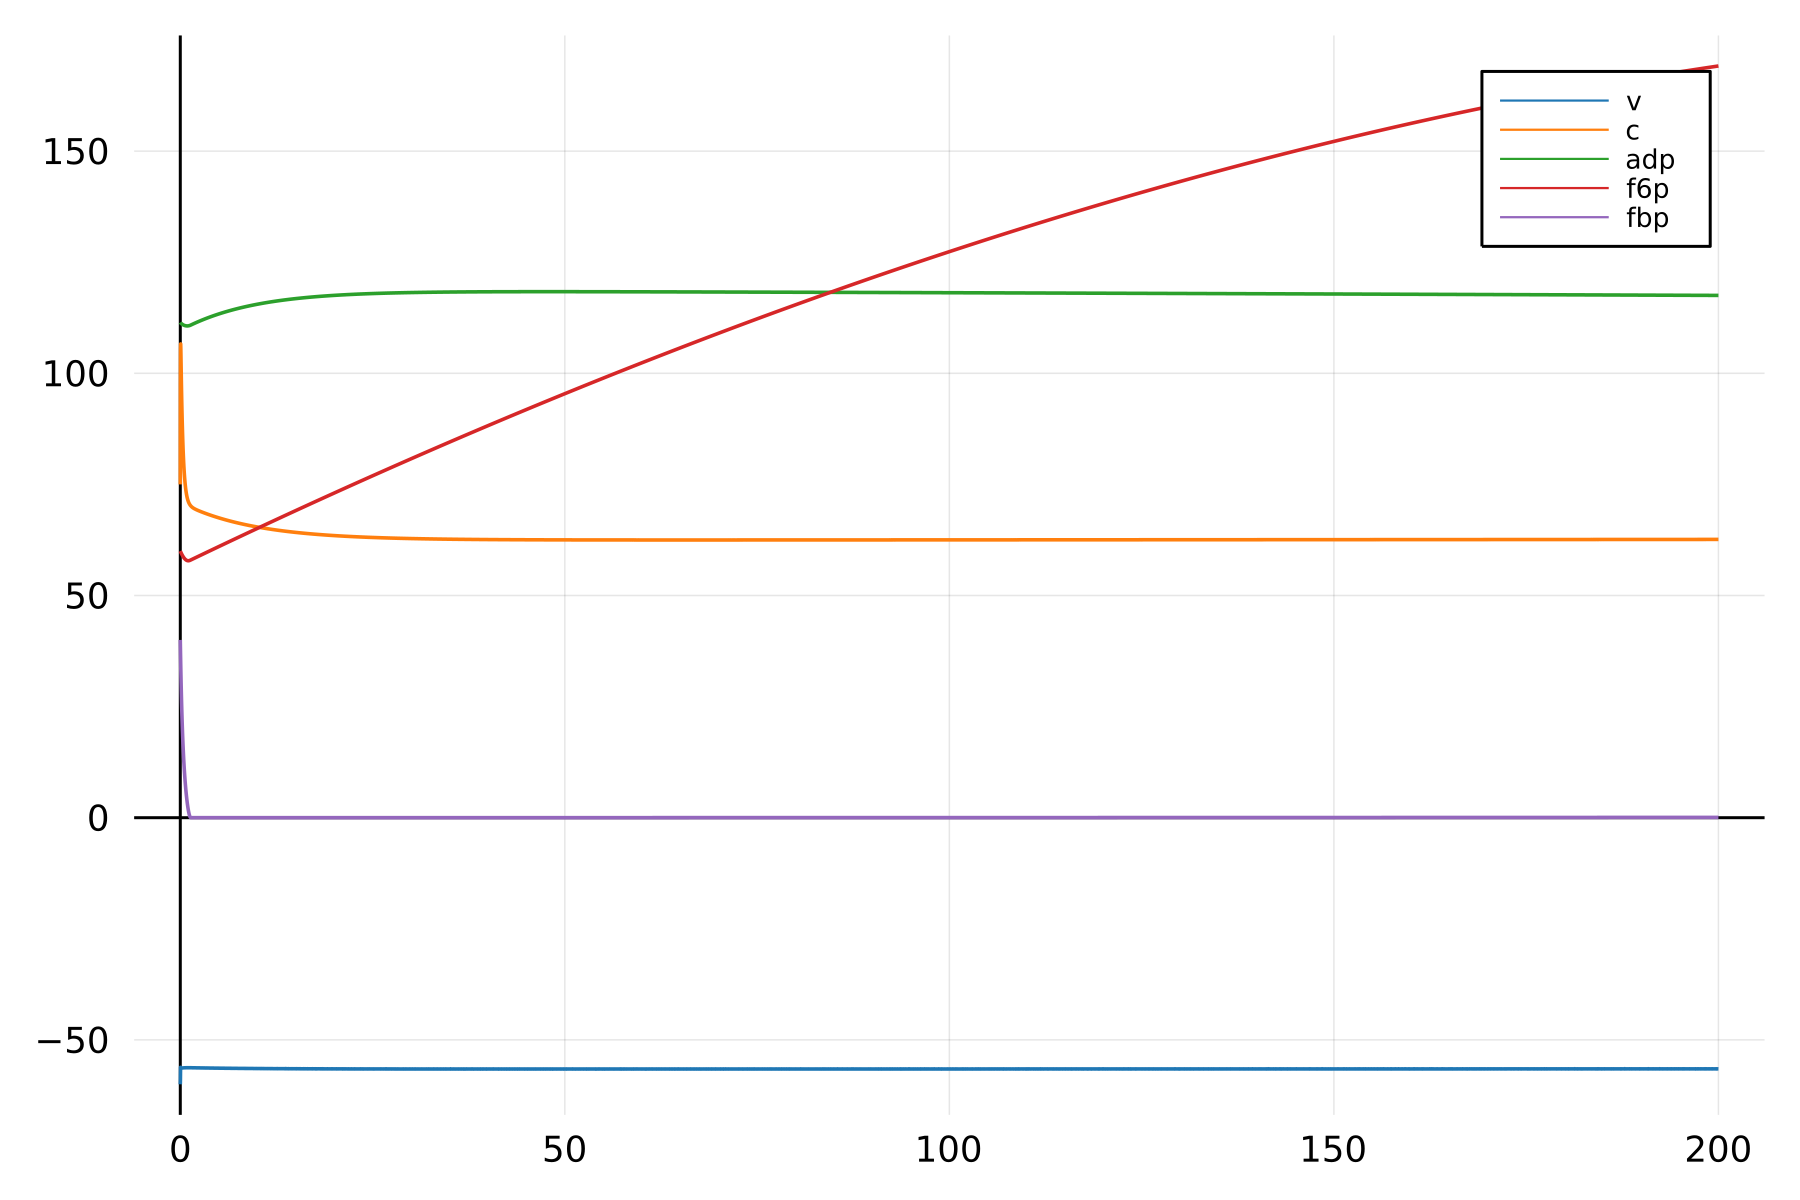

In [51]:
settings = (
    ode_func      = sys,
    y0            = y0,
    time          = 200 * 6000,
    plot_args     = Dict(),
    params        = reset_params(),
    plot_params   = [1,3,6,7,8],
    change_params = Dict(
           "vpdh" => 0.02,
            "gkca" => 100,
            "Jgk" => 0.0005,
        ),
    meds = [Med(10000000, "Dz", 10)]
);

stats = setupstats()
#_, _, plots, p = loopvals("Jgk", [0.002, 0.003, 0.004, 0.005], settings)
s,m,p = simulate(settings)

#plot(sortedvalues(plots)..., dpi=300, label=["V" "C" "V" "C" "V" "C" "V" "C"])
plot(p)

In [52]:
#vec_to_matrix(s.u)[:,2][1:20:end]
for key in keys(stats)
    pushfirst!(stats[key], 0)
end

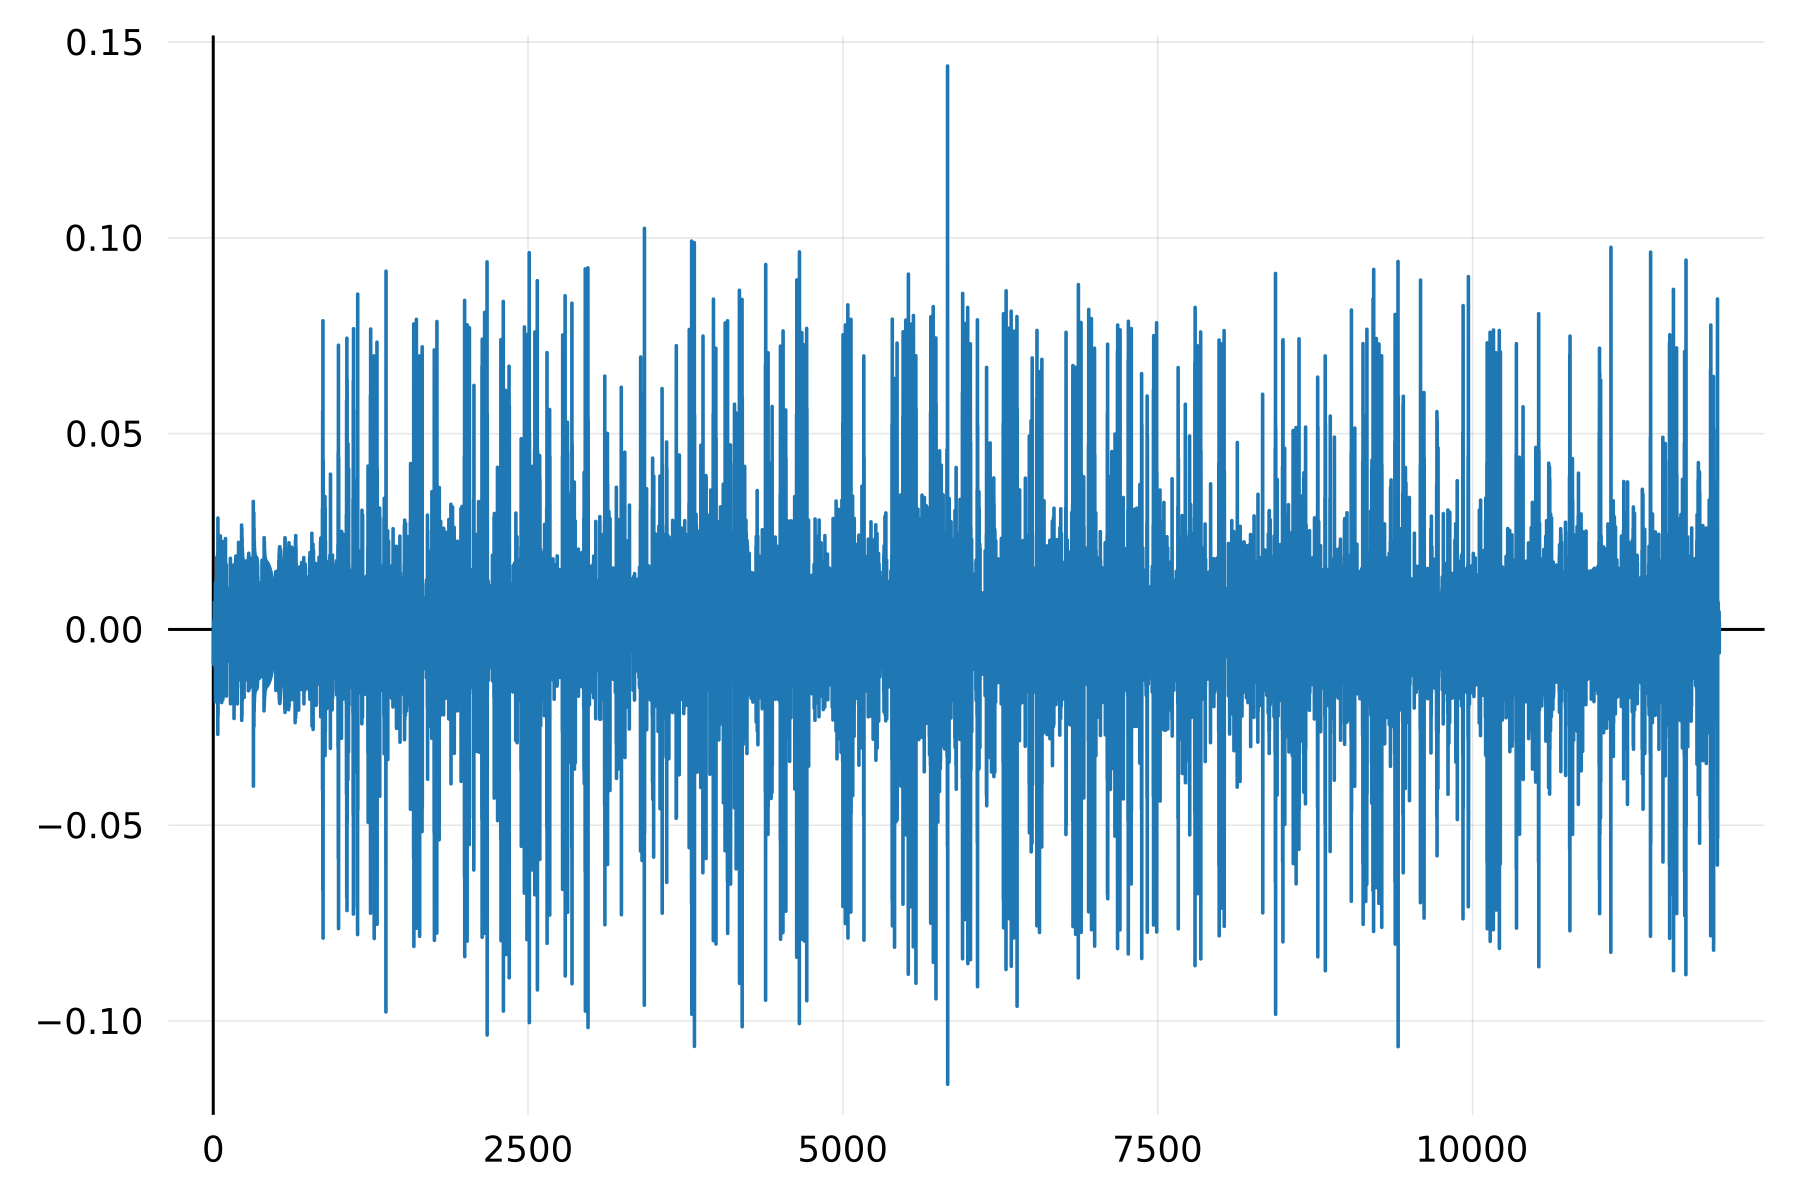

In [53]:
plot(vecdiff(stats["vk"][40:end]), legend=false)

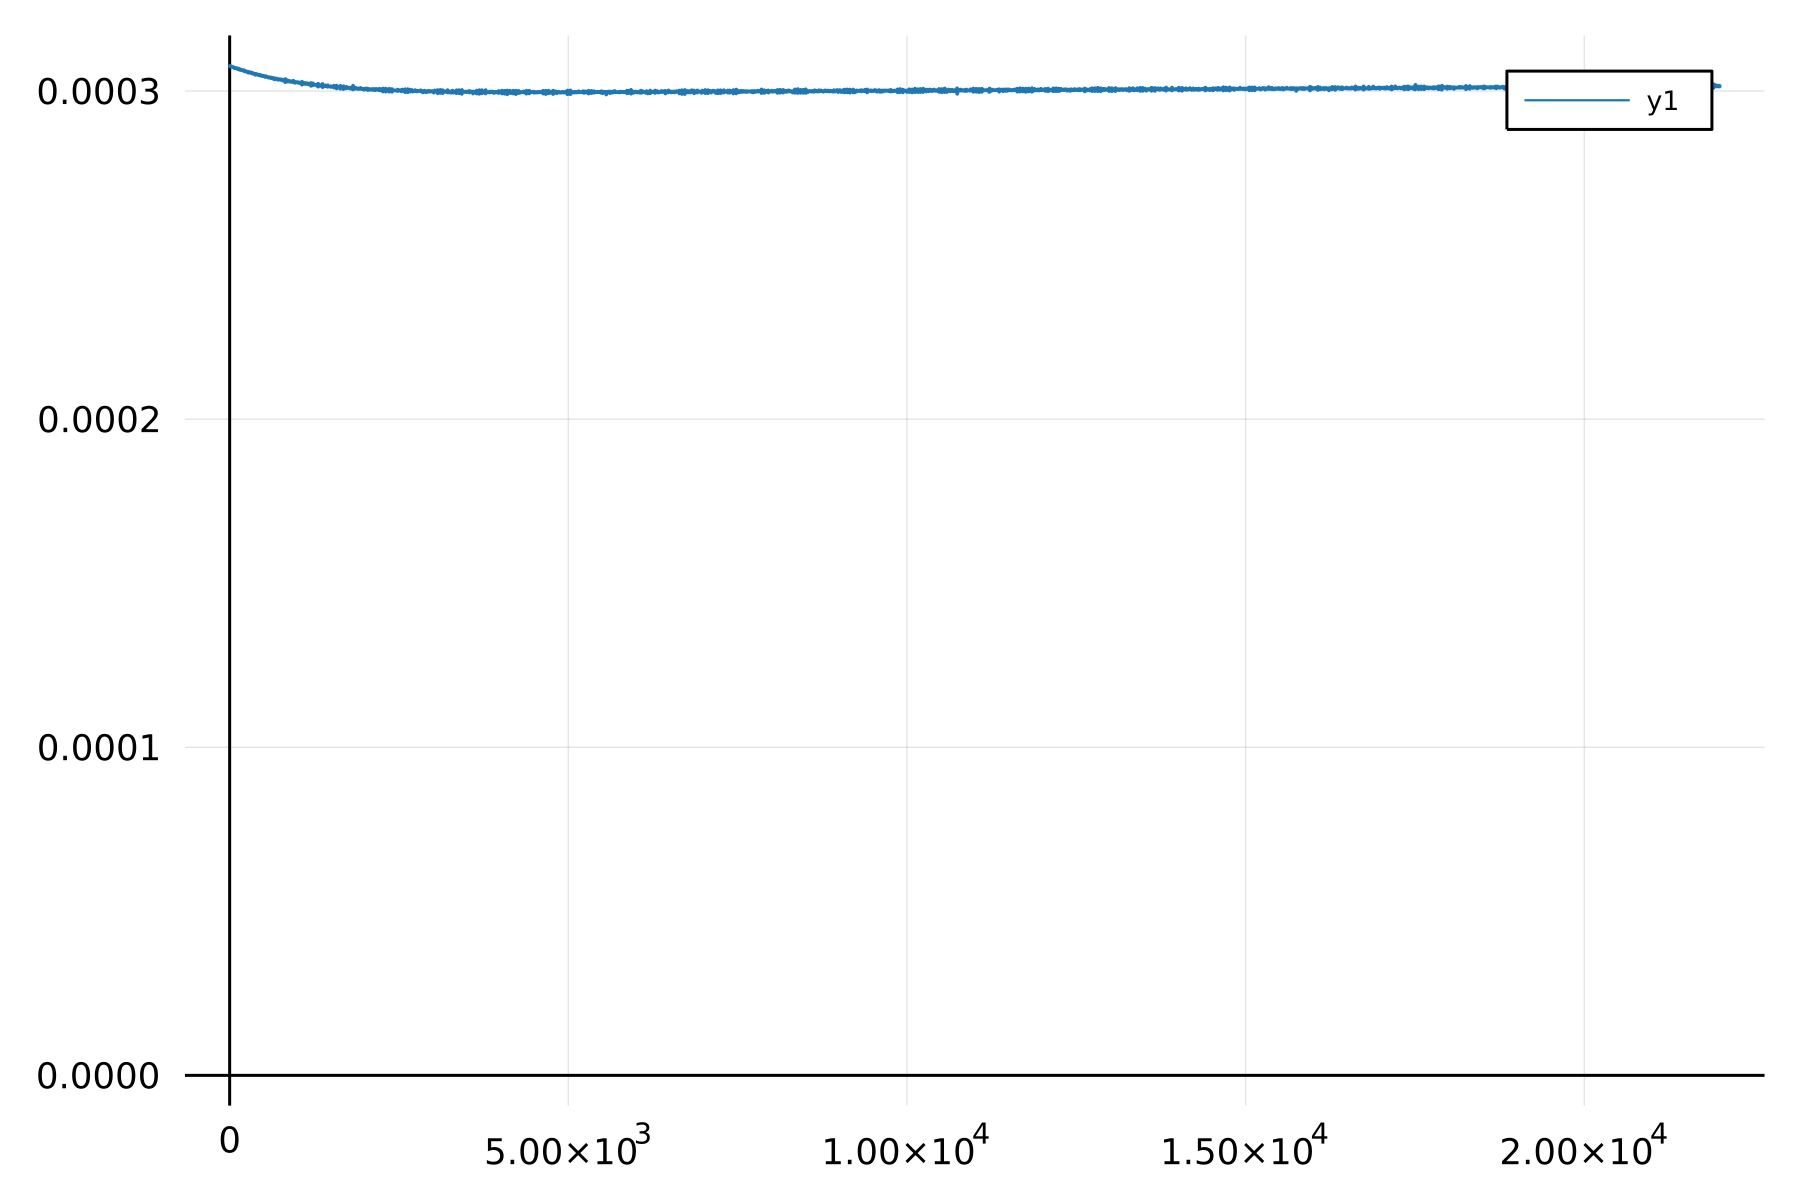

In [54]:
plot(vec_to_matrix(s.u)[:,2][1000:23000])


Dict{String, Vector{Any}}("gkatpbar" => [], "gca" => [], "gkca" => [], "t" => [], "vk" => [])
  2.600011 seconds (64.60 M allocations: 1015.140 MiB, 10.68% gc time)


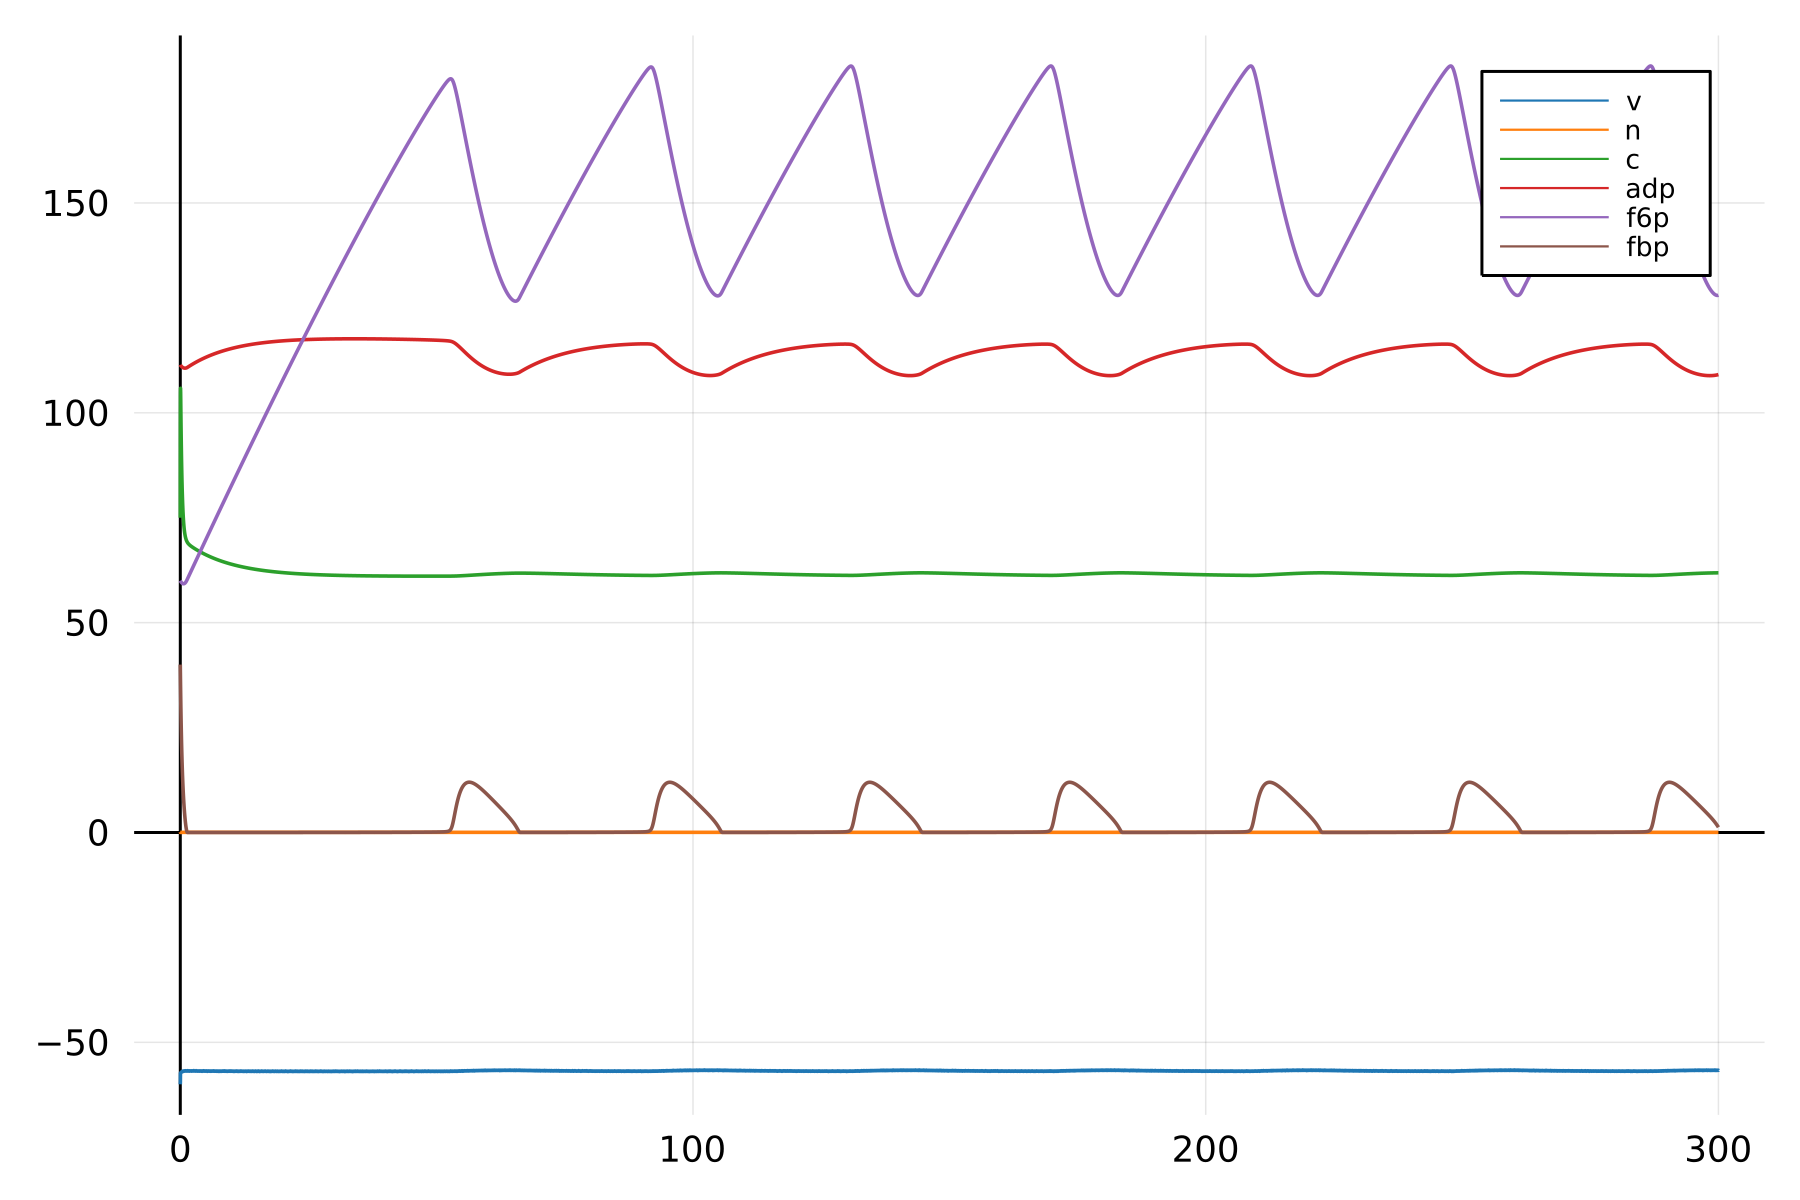

In [55]:
settings = (
    ode_func      = sys,
    y0            = y0,
    time          = 300 * 6000,
    plot_args     = Dict(),
    params        = reset_params(),
    plot_params   = [1,2,3,6,7,8],
    change_params = Dict(
           "vpdh" => 0.02,
            "gkca" => 900,
            "Jgk" => 0.0015,
        ),
);

stats = setupstats()
println(stats)

#s, sm, plots, p = loopvals("Jgk", [0.0005, 0.001, 0.0015, 0.002], settings)
s,sm,p = simulate(settings)

plot(p)

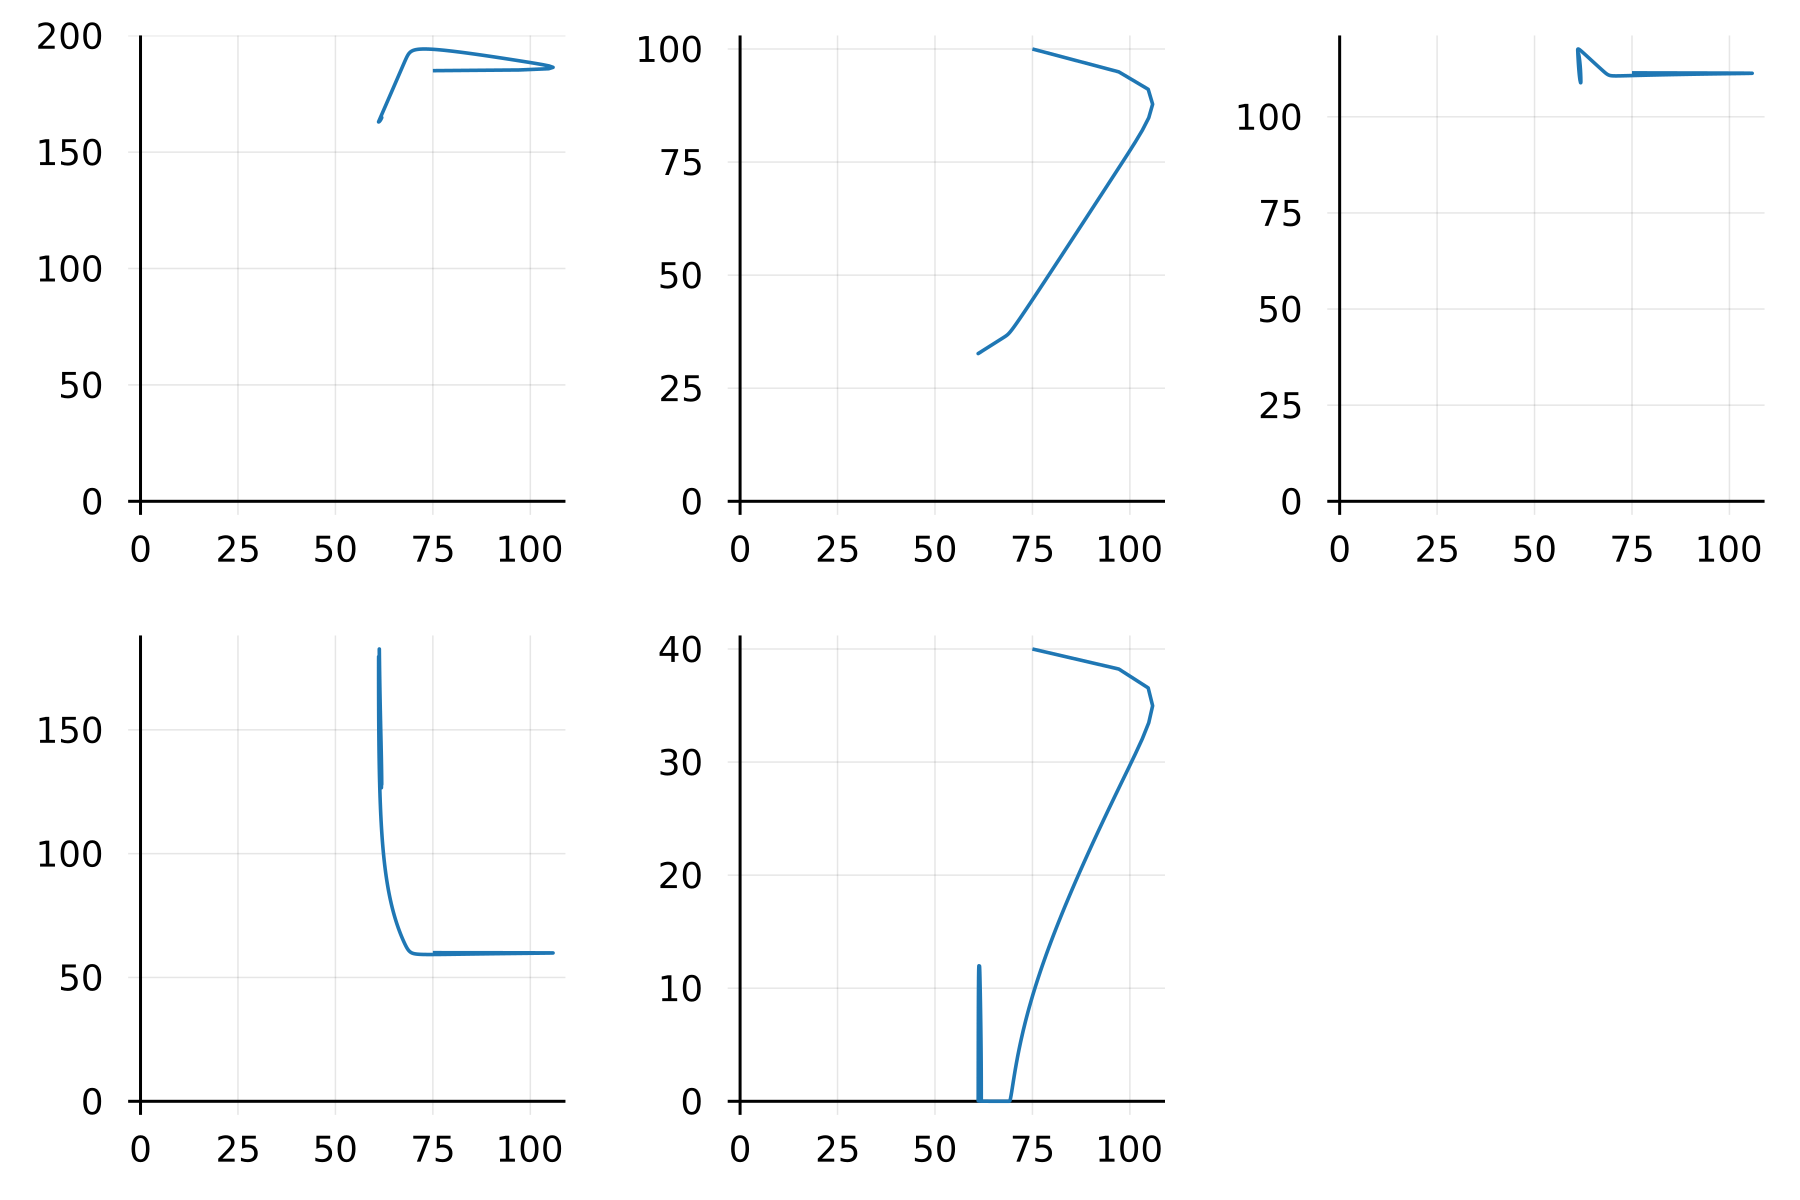

In [56]:
plot(
plot(sm[:,3] ,sm[:,4]),
plot(sm[:,3] ,sm[:,5]),
plot(sm[:,3] ,sm[:,6]),
plot(sm[:,3] ,sm[:,7]),
plot(sm[:,3] ,sm[:,8]),
    legend = false,
    )

In [57]:
stats["vk"]

Any[]